# Galassify

## Aplicación de Deep autoencoder para clusterización con dataset v3-2k

Aunque posiblemente no sea el tipo de autoencoder que finalmente dé mayor accuracy, usamos de momento este modelo para avanzar en el proceso de clustering y crear un PMV lo antes posible.

Usaremos 100 variables en el espacio latente

### Importación de librerías y carga de datos

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.spatial import distance
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN 
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

import hdbscan

from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten
from keras.layers import LSTM, RepeatVector, TimeDistributed
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam

%matplotlib inline
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)



/home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.


Si tenemos grabado el modelo del autoencoder, poner esta variable a False (y guardar el archivo h5 con el modelo en la misma carpeta que el notebook.

En caso contrario, poner a True

In [2]:
# variable para entrenar todo el modelo o cargarlo por estar hecho en otro notebook
entrenar = False

In [3]:
data = pd.read_csv("./data/datasetV3_2K.csv", sep=";")
data.head()

PLATE    MJD  FIBER         Z  3830.58019920364  3831.4614191445135  \
0   2080  53350    306  0.102644          0.197380            0.091197   
1   6597  56304    518  0.195175          0.288892            0.247143   
2   1209  52674    313  0.048895          0.885628            0.606963   
3    471  51924    357  0.130454          0.301350            0.286676   
4   2245  54208    357  0.131206          0.567914            0.594087   

   3832.344945685447  3833.2265716039287  3834.110505185121  \
0           0.071095            0.204710           0.231629   
1           0.219803            0.265407           0.304205   
2           0.534335            0.498242           0.410452   
3           0.255201            0.288648           0.241975   
4           0.627600            0.650115           0.487720   

   3834.992537268245  3835.8768780772193  3836.7593165121057  \
0           0.237486            0.238463            0.192779   
1           0.262629            0.257806            0.283138   
2           0.495976            0.478329            0.446385   
3           0.268519            0.194541            0.044752   
4           0.318347            0.406080            0.426644   

   3837.641957950795  3838.526909710328  3839.4099577815086  \
0           0.180288           0.184200            0.201943   
1           0.280235           0.281053            0.292201   
2           0.558115           0.627039            0.616725   
3           0.064262           0.200550            0.275189   
4           0.255343           0.072600            0.099993   

   3840.2953172378966  3841.178772128906  3842.0645394699764  \
0            0.426566           0.333191            0.251851   
1            0.423150           0.400697            0.281589   
2            0.660746           0.665512            0.610210   
3            0.245838           0.290062            0.414549   
4            0.270817           0.457282            0.582655   

   3842.948401368234  3843.832466597762  3844.718845874915  \
0           0.418486           0.377863           0.304034   
1           0.348663           0.387479           0.310455   
2           0.657121           0.793353           0.856607   
3           0.381571           0.421015           0.427070   
4           0.426056           0.287767           0.536856   

   3845.6033183928735  3846.490106024541  3847.3749860185694  \
0            0.414950           0.424607            0.305737   
1            0.226694           0.255639            0.401858   
2            0.857025           0.886865            0.912122   
3            0.406793           0.365717            0.212966   
4            0.741087           0.638603            0.667595   

   3848.2621821928774  3849.1474698507  3850.032961167784  3850.9207702652907  \
0            0.283129         0.256632           0.215276            0.479698   
1            0.481925         0.407332           0.363757            0.411702   
2            0.930173         0.936705           0.856260            0.821993   
3            0.443403         0.706384           0.629723            0.653688   
4            0.764384         0.669262           0.688363            0.748669   

   3851.8066695278053  3852.694887638543  3853.581195034427  \
0            0.419432           0.461091           0.130793   
1            0.293535           0.311165           0.486831   
2            0.821516           0.808307           0.823193   
3            0.632059           0.458916           0.653285   
4            0.699740           0.678007           0.584040   

   3854.4698223468267  3855.356538064109  3856.2434577691774  \
0            0.087730           0.267335            0.448290   
1            0.426038           0.364969            0.335684   
2            0.850489           0.876013            0.851607   
3            0.755927           0.556198            0.235380   
4            0.475033           0.582643            0.643433   

   3857.1326989934832

¡Ojo! Para el entrenamiento, no necesitamos trazabilidad de los espectros (y estos campos nos estorban para meterlos en la red neuronal), pero después habrá que recuperar los valores de plate, MJD, Fiber y Z para poder saber de qué galaxia estamos hablando.

In [4]:
frecuencias = data.columns[4:]
frecuencias

Index(['3830.58019920364', '3831.4614191445135', '3832.344945685447',
       '3833.2265716039287', '3834.110505185121', '3834.992537268245',
       '3835.8768780772193', '3836.7593165121057', '3837.641957950795',
       '3838.526909710328',
       ...
       '7484.530308508518', '7486.252114870202', '7487.978428073448',
       '7489.701027670507', '7491.42813618543', '7493.1515293833045',
       '7494.879433576302', '7496.603620740605', '7498.328204551902',
       '7500.057302474759'],
      dtype='object', length=2919)

In [5]:
data = data[frecuencias]
data.head()

3830.58019920364  3831.4614191445135  3832.344945685447  \
0          0.197380            0.091197           0.071095   
1          0.288892            0.247143           0.219803   
2          0.885628            0.606963           0.534335   
3          0.301350            0.286676           0.255201   
4          0.567914            0.594087           0.627600   

   3833.2265716039287  3834.110505185121  3834.992537268245  \
0            0.204710           0.231629           0.237486   
1            0.265407           0.304205           0.262629   
2            0.498242           0.410452           0.495976   
3            0.288648           0.241975           0.268519   
4            0.650115           0.487720           0.318347   

   3835.8768780772193  3836.7593165121057  3837.641957950795  \
0            0.238463            0.192779           0.180288   
1            0.257806            0.283138           0.280235   
2            0.478329            0.446385           0.558115   
3            0.194541            0.044752           0.064262   
4            0.406080            0.426644           0.255343   

   3838.526909710328  3839.4099577815086  3840.2953172378966  \
0           0.184200            0.201943            0.426566   
1           0.281053            0.292201            0.423150   
2           0.627039            0.616725            0.660746   
3           0.200550            0.275189            0.245838   
4           0.072600            0.099993            0.270817   

   3841.178772128906  3842.0645394699764  3842.948401368234  \
0           0.333191            0.251851           0.418486   
1           0.400697            0.281589           0.348663   
2           0.665512            0.610210           0.657121   
3           0.290062            0.414549           0.381571   
4           0.457282            0.582655           0.426056   

   3843.832466597762  3844.718845874915  3845.6033183928735  \
0           0.377863           0.304034            0.414950   
1           0.387479           0.310455            0.226694   
2           0.793353           0.856607            0.857025   
3           0.421015           0.427070            0.406793   
4           0.287767           0.536856            0.741087   

   3846.490106024541  3847.3749860185694  3848.2621821928774  3849.1474698507  \
0           0.424607            0.305737            0.283129         0.256632   
1           0.255639            0.401858            0.481925         0.407332   
2           0.886865            0.912122            0.930173         0.936705   
3           0.365717            0.212966            0.443403         0.706384   
4           0.638603            0.667595            0.764384         0.669262   

   3850.032961167784  3850.9207702652907  3851.8066695278053  \
0           0.215276            0.479698            0.419432   
1           0.363757            0.411702            0.293535   
2           0.856260            0.821993            0.821516   
3           0.629723            0.653688            0.632059   
4           0.688363            0.748669            0.699740   

   3852.694887638543  3853.581195034427  3854.4698223468267  \
0           0.461091           0.130793            0.087730   
1           0.311165           0.486831            0.426038   
2           0.808307           0.823193            0.850489   
3           0.458916           0.653285            0.755927   
4           0.678007           0.584040            0.475033   

   3855.356538064109  3856.2434577691774  3857.1326989934832  \
0           0.267335            0.448290            0.371415   
1           0.364969            0.335684            0.306989   
2           0.876013            0.851607            0.887033   
3           0.556198            0.235380            0.241689   
4           0.582643            0.643433            0.635931   

   3858.0200273020373  3858.909678199355  3859.797415299641  \
0            0.244046   

Se detecta que existen espectros donde el valor del flux es negativo, lo que no es posible. Se debe a un error en la lectura. Vamos a ver el tamaño de este problema.

In [6]:
# Vamos a detectar espectros en los que uno o más valores son negativos (no podemos asegurar que habrá un único
# valor negativo)

negativos = []
for i in range(len(data)):
    if any(data.iloc[i] < 0):
        negativos.append((i, sum(n < 0 for n in data.iloc[i])))
        
len(negativos)

618

In [7]:
sum([negativos[i][1] for i in range(len(negativos))])

16030

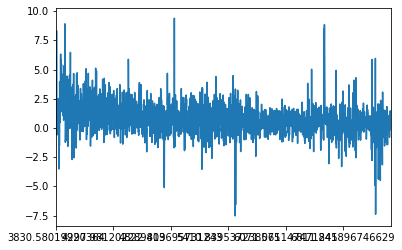

In [8]:
data.iloc[46].plot();

In [9]:
data.shape

(1954, 2919)

In [10]:
16030*100/(data.shape[0]*data.shape[1])

0.28104435591751775

Un 0,28% de todos los valores de frecuencias son negativos, es decir, erróneos (no puede haber cantiddes de flux negativas, es decir "luz" negativa). Esto podría disminuir la confianza en la fiabilidad de los datos del dataset.

Además de haber bastantes valores erróneos, disminuyen mucho el valor mínimo de muchos espectros, haciendo que la estandarización que vamos a hacer después comprima demasiado los valores correctos (lo que hace que casi todos los espectros estandarizados "parezcan iguales".

Por esto, vamos a corregir la situación con la siguiente estrategia:

* Se eliminarán aquellos espectros que tengan dos o más valores negativos (se considerará que ha existido algún error de lectura que puede comprometer la fiabilidad de todo el espectro).
* En los restantes, se cambiará el único valor negativo por el valor correspondiente al continuum, tomando como tal el valor de la media móvil de 20 periodos en ese punto.

In [11]:
# Eliminamos los espectros con dos o más valores negativos
for i in negativos:
    if i[1]>1:
        data.drop(i[0], axis=0, inplace=True)
data.shape       

(1563, 2919)

In [12]:
# Y ahora tratamos los espectros con un solo valor negativo. En estos casos, esa frecuencia tendrá el valor de
# flux mínimo del espectro

# Función recogida en StackOverFlow. Devuelve el valor de posición en el array más cercano al "target"
# Entradas: A, el array a considerar, y el target o valor a buscar.
# En este caso, hay que tener en cuenta que la frecuencia a buscar es el índice en el dataset
def find_closest(A, target): 
    #A must be sorted
    idx = A.searchsorted(target)
    idx = np.clip(idx, 1, len(A)-1)
    left = A[idx-1]
    right = A[idx]
    idx -= target - left < right - target
    return idx


# En esta función se calcula la media móvil con un número variable de peridos. Los parámetros de entrada son:
# - espectro, la pd.Serie con el espectro completo a corregir. Tiene como índice la frecuencia.
# - frecuencia, el valor de la frecucncia cuyo flux es negativo. Se corresponde con el mínimo de la "función
#   espectro". Debe llegar como float.
# - periodo, el de la media móvila considerar. Se tiene 20 por defecto (se ajusta bien al espectro medio)
def media_movil(espectro, frecuencia, periodo = 20):
    sma = espectro.rolling(periodo).mean() # sma es la media móvil de todo el espectro
    # Calculamos el valor de sma en la frecuencia dada
    if frecuencia < float(sma.index[periodo]):   # La Serie de sma no tiene valores para los primeros 20 valores
        frecuencia = float(sma.index[periodo])
    indice_sma = pd.to_numeric(sma.index)
    
    # Por alguna razón al tratar los índices y convertirlos de str a float, se producen errores al reconocer valores
    # en casos contados. Para evitarlo, tomamos el valor de frecuencia más cercano
    if frecuencia in indice_sma:
        # Tomamos como valor del flux el de la media móvil en la frecuencia problemática 
        return sma[indice_sma==frecuencia]
    else:
        # Es en estos casos cuando surge el error: tomamos el valor de la siguiente frecuencia a la problemática
        print("¡No esta!")
        frecuencia = float(sma.index[find_closest(indice_sma, frecuencia)+1])
        print(frecuencia)
        return sma[indice_sma==frecuencia]
    

In [13]:
# Aquí corregimos los valores de flux negativos por los de la media móvil, con la ayuda de la función definida
for i in range(len(data)):
    if any(data.iloc[i] < 0):
        data.iloc[i][data.iloc[i].index==data.iloc[i].idxmin()] = media_movil(data.iloc[i], float(data.iloc[i].idxmin()))[0]

¡No esta!
7361.470036745908
¡No esta!
5070.660165887807
¡No esta!
4880.5033101925765


In [14]:
data.to_csv("./espectros_2k_sin_negativos.csv")

Para luego entrenar los modelos y tener un set de test para las medidas de accuracy, dividimos el dataset en train y test (nos vale un 15% para el test). Recordemos que estamos usando un aprendizaje no supervisado y no tenemos etiquetas.

In [19]:
espectros_train, espectros_test, _, _ = train_test_split(data, data, test_size=0.15, random_state=21)

Ahora podemos seguir con el proceso, primero estandarizando el dataset

In [45]:
scaler = MinMaxScaler() # = np.array(data.apply(lambda x: (x-x.min()) / (x.max()-x.min())))
scaler.fit(espectros_train)
espectros_train_scaled = pd.DataFrame(scaler.transform(espectros_train), 
                               columns=espectros_train.columns,
                               index=espectros_train.index)
espectros_test_scaled = pd.DataFrame(scaler.transform(espectros_test),
                             columns=espectros_test.columns,
                             index=espectros_test.index)
# Esta es la versiós estandarizada de todo el dataset para comparaciones posteriores
espectros_scaled = pd.DataFrame(scaler.transform(data), 
                               columns=data.columns,
                               index=data.index)
espectros_train_scaled.head()

3830.58019920364  3831.4614191445135  3832.344945685447  \
1515          0.609595            0.583632           0.722986   
497           0.121958            0.115751           0.114736   
476           0.101923            0.142373           0.199622   
747           0.157706            0.138805           0.146947   
1812          0.073813            0.080524           0.133025   

      3833.2265716039287  3834.110505185121  3834.992537268245  \
1515            0.516955           0.383090           0.537671   
497             0.162028           0.190130           0.122087   
476             0.178793           0.143416           0.102384   
747             0.133677           0.108158           0.106324   
1812            0.133237           0.144390           0.144540   

      3835.8768780772193  3836.7593165121057  3837.641957950795  \
1515            0.639145            0.547752           0.572901   
497             0.082002            0.040682           0.072661   
476             0.129215            0.113745           0.131148   
747             0.144529            0.136307           0.145356   
1812            0.123031            0.082234           0.088180   

      3838.526909710328  3839.4099577815086  3840.2953172378966  \
1515           0.565917            0.616575            0.734738   
497            0.138495            0.201501            0.248390   
476            0.150123            0.125042            0.091009   
747            0.181772            0.181216            0.149811   
1812           0.118047            0.123318            0.177156   

      3841.178772128906  3842.0645394699764  3842.948401368234  \
1515           0.662285            0.676618           0.839499   
497            0.189142            0.130475           0.104205   
476            0.143923            0.228207           0.162958   
747            0.146234            0.147162           0.197250   
1812           0.272922            0.225673           0.149514   

      3843.832466597762  3844.718845874915  3845.6033183928735  \
1515           0.941513           0.725880            0.601166   
497            0.130574           0.151581            0.151905   
476            0.122430           0.189604            0.211971   
747            0.256122           0.207892            0.150220   
1812           0.140155           0.141348            0.148103   

      3846.490106024541  3847.3749860185694  3848.2621821928774  \
1515           0.545068            0.544806            0.439502   
497            0.116047            0.148560            0.145596   
476            0.208732            0.227760            0.139766   
747            0.128936            0.153508            0.095327   
1812           0.163077            0.218040            0.111930   

      3849.1474698507  3850.032961167784  3850.9207702652907  \
1515         0.808418           0.902901            0.703763   
497          0.174001           0.090203            0.071348   
476          0.202749           0.167830            0.080942   
747          0.113398           0.059438            0.063003   
1812         0.111472           0.100407            0.071766   

      3851.8066695278053  3852.694887638543  3853.581195034427  \
1515            0.630870           0.770349           0.960061   
497             0.101079           0.131196           0.087869   
476             0.061933           0.120636           0.154785   
747             0.064612           0.092992           0.116307   
1812            0.072672           0.135387           0.193887   

      3854.4698223468267  3855.356538064109  3856.2434577691774  \
1515            0.670346           0.873329            1.000000   
497             0.152734           0.184648            0.209811   
476             0.181882           0.203035            0.221167   
747             0.128156           0.109509            0.149871   
1812            0.178830           0.159247            0.181079   

      3857.1326989934832  3858

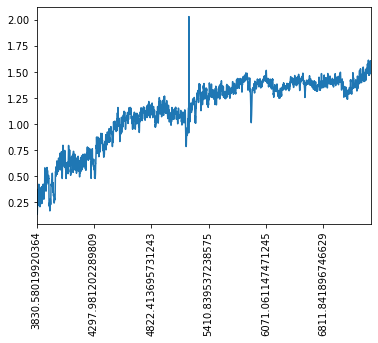

In [23]:
# Un espectro original cualquiera (el de índice 16 en este caso)
espectros_train.iloc[16].plot();
plt.xticks(rotation=90);

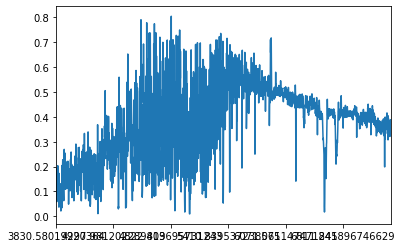

In [25]:
# El mismo espectro, pero con valores estandarizados
espectros_train_scaled.iloc[16].plot();

Definimos aquí el tamaño del espacio latente. Aunque se ha probado hasta con un valor de 5 y el autoencoder lo soporta perfectamente (por debajo de 50 podría ser que la representación estandarizada de salida tras el decoder presente bastantes problemas de fidelidad con respecto al del entrada), lo aumentamos aquí a 100 con la intención de generar un mayor número de clusters en DBSCAN.

In [28]:
dim_latente = 100

In [23]:
espectros_train_scaled.shape

(1328, 2919)

In [30]:
dim_input = espectros_train_scaled.shape[1]
dim_input

2919

In [31]:
# Función para mostrar la gráfica de evolución de train loss y val loss en cada epoch durante el entrenamiento 
def grafica_loss(modelo, n_epochs):
    loss = modelo.history.history['loss']
    val_loss = modelo.history.history['val_loss']
    epochs = range(n_epochs)
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Test loss')
    plt.title('Error de Training y Test')
    plt.legend()

### Autoencoder deep

Se ha probado com 'mse', pero parece que los mejores resultados siguen dándose con un error de tipo 'binary_crossentropy'. Dado que los valores de entrada siempre son positivos, no tenía sentido usar selu en vez de relu como función de activación. La optimización sigue siendo "adadelta" ("ada" da resultados mucho peores).

En cuanto al número de epochs, se pone 40, dado que la mejora en la parte final empieza ya a degradarse (ver gráfica de loss). Además, si nos pasamos en número de epochs, la red se desestabiliza en muchas ocasiones.

En cuanto a la arquitectura de capas ocultas, no parece que el rendimiento varíe mucho al disminuirlo considerablemente, incluso quitando una capa en el encoder y su simétrica en el decoder.

Train on 1328 samples, validate on 235 samples
Epoch 1/40
1328/1328 [==============================] - 3s 2ms/step - loss: 0.6929 - acc: 7.5662e-04 - val_loss: 0.6924 - val_acc: 0.0000e+00
Epoch 2/40
1328/1328 [==============================] - 2s 1ms/step - loss: 0.6919 - acc: 7.4888e-04 - val_loss: 0.6910 - val_acc: 0.0000e+00
Epoch 3/40
1328/1328 [==============================] - 1s 1ms/step - loss: 0.6898 - acc: 7.5430e-04 - val_loss: 0.6873 - val_acc: 0.0000e+00
Epoch 4/40
1328/1328 [==============================] - 2s 1ms/step - loss: 0.6834 - acc: 7.5946e-04 - val_loss: 0.6757 - val_acc: 0.0000e+00
Epoch 5/40
1328/1328 [==============================] - 1s 1ms/step - loss: 0.6661 - acc: 7.4888e-04 - val_loss: 0.6519 - val_acc: 0.0000e+00
Epoch 6/40
1328/1328 [==============================] - 1s 1ms/step - loss: 0.6423 - acc: 7.3779e-04 - val_loss: 0.6331 - val_acc: 0.0000e+00
Epoch 7/40
1328/1328 [==============================] - 1s 1ms/step - loss: 0.6294 - acc: 7.4966e-04 

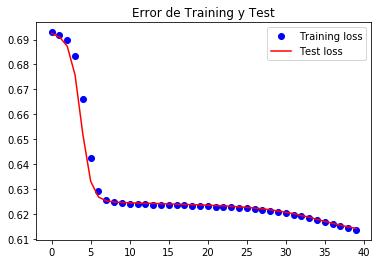

In [39]:
epochs = 40

if entrenar:
    input = Input(shape=((dim_input, )))
    encoded = Dense(1000, activation='relu')(input)
    encoded = Dense(500, activation='relu')(encoded)
    encoded = Dense(dim_latente, activation='relu')(encoded)
    decoded = Dense(500, activation='relu')(encoded)
    decoded = Dense(1000, activation='relu')(decoded)
    decoded = Dense(dim_input, activation='sigmoid')(decoded)

    # Modelo para obtener el autoencoder completo
    autoencoder_deep = Model(input, decoded)
    
    # Modelo para obtener el espacio latente
    encoder = Model(input, encoded)
    
    autoencoder_deep.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=["accuracy"])
    autoencoder_deep.fit(espectros_train_scaled, espectros_train_scaled,
                epochs=epochs,
                batch_size=128,
                shuffle=True,
                validation_data=(espectros_test_scaled, espectros_test_scaled))  
    grafica_loss(autoencoder_deep, epochs)
    autoencoder_deep.save('model_deep2k_lat_100.h5')
    encoder.save("model_encoder_deep2k_lat_100.h5")
    

else:
    autoencoder_deep = load_model('model_deep2k_lat_100.h5')
    encoder = load_model("model_encoder_deep2k_lat_100.h5")
    
autoencoder_deep.summary()

In [40]:
# Este es el modelo con el que obtenemos la representación latente de los espectros del test_set
espectro_encoded = encoder.predict(espectros_test_scaled) 

# Esta es la salida del autoencoder, para comprobar si se parece a la entrada
espectro_decoded = autoencoder_deep.predict(espectros_test_scaled) 

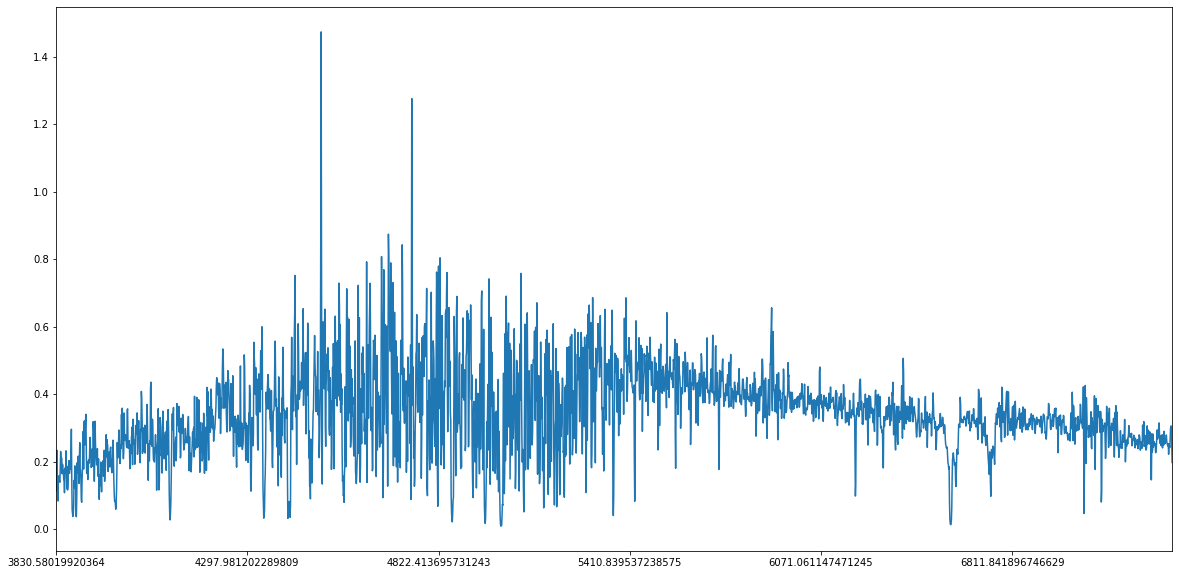

In [41]:
# Un espectro de entrada cualquier (en esta ocasión el de índice 100). recordemos que está estandarizado
plt.figure(figsize=(20, 10))
espectros_test_scaled.iloc[100].plot();

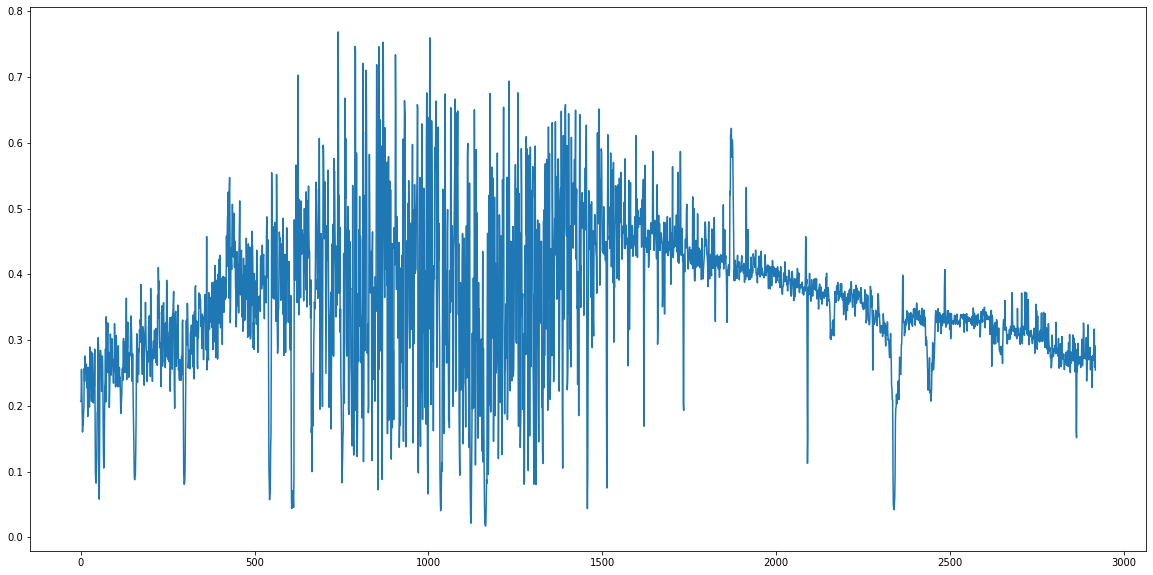

In [42]:
# Su reproducción por el decoder
plt.figure(figsize=(20, 10))
plt.plot(espectro_decoded[100]);

Hay que tener en cuenta que el autoencoder solo va a dar valores entre 0 y 1 y que en algunos casos la imagen de entrada tiene valores por encima de 1.

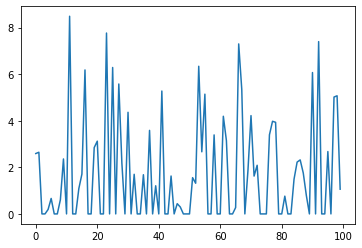

In [37]:
# La representación latente del mismo espectro
plt.plot(espectro_encoded[100]);

Por tanto vamos a usar el modelo anterior sobre todos los espectros de que disponemos (partiendo de todo el dataset estandarizado) y recoger la representanción latente de los mismos.

In [43]:
espectros_latentes = encoder.predict(data)

Por tanto, tenemos en "data" los espectros originales sin estandarizar; en "espectros" tenemos los mismos escalados; y en "espectros_latentes" tenemos la representación latente de cada espectro.

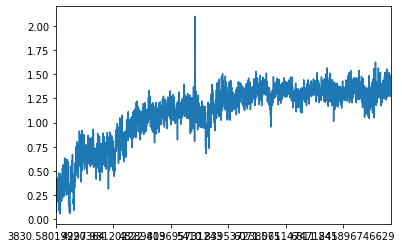

In [44]:
data.iloc[0].plot()

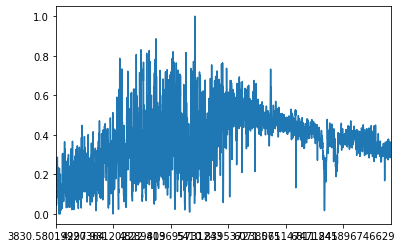

In [46]:
espectros_scaled.iloc[0].plot();

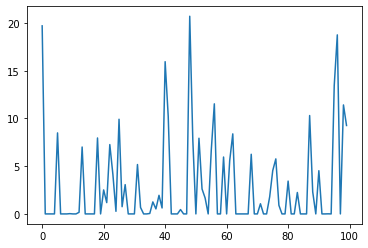

In [47]:
plt.plot(espectros_latentes[0]);

## Aplicación de algoritmos de clustering

## 1.- DBSCAN

DBSCAN tiene dos parámetros:

* eps, que es la distancia mínima para considerar a dos muestras como del mismo cluster
* min_samples, que es el número de muestras mínimo que debe contener un cluster.

Cuando una muestra no llegue al número mínimo del clusters, se considerará outlier y DBSCAN la etiquetará como -1.

Para ajustar mejor el parámetro eps, vamos a ir probando con un bucle que recorra eps desde 0,1 a 2 y visualizar los resultados. Intentamos maximizar el número de clusters sin que se dispare el número de outliers.

In [52]:
num_clusters = []
num_outliers = []
rango = np.arange (0.1, 2, 0.01)
for eps in rango:
    np.random.seed(21)
    clustering = DBSCAN(eps=eps, min_samples=2, n_jobs=-1).fit(espectros_latentes)
    labels = np.unique(clustering.labels_, return_counts=True)
    num_clusters.append(len(labels[0]))
    num_outliers.append(labels[1][0])
                        

In [54]:
labels

(array([-1,  0,  1,  2,  3]), array([  34, 1522,    2,    3,    2]))

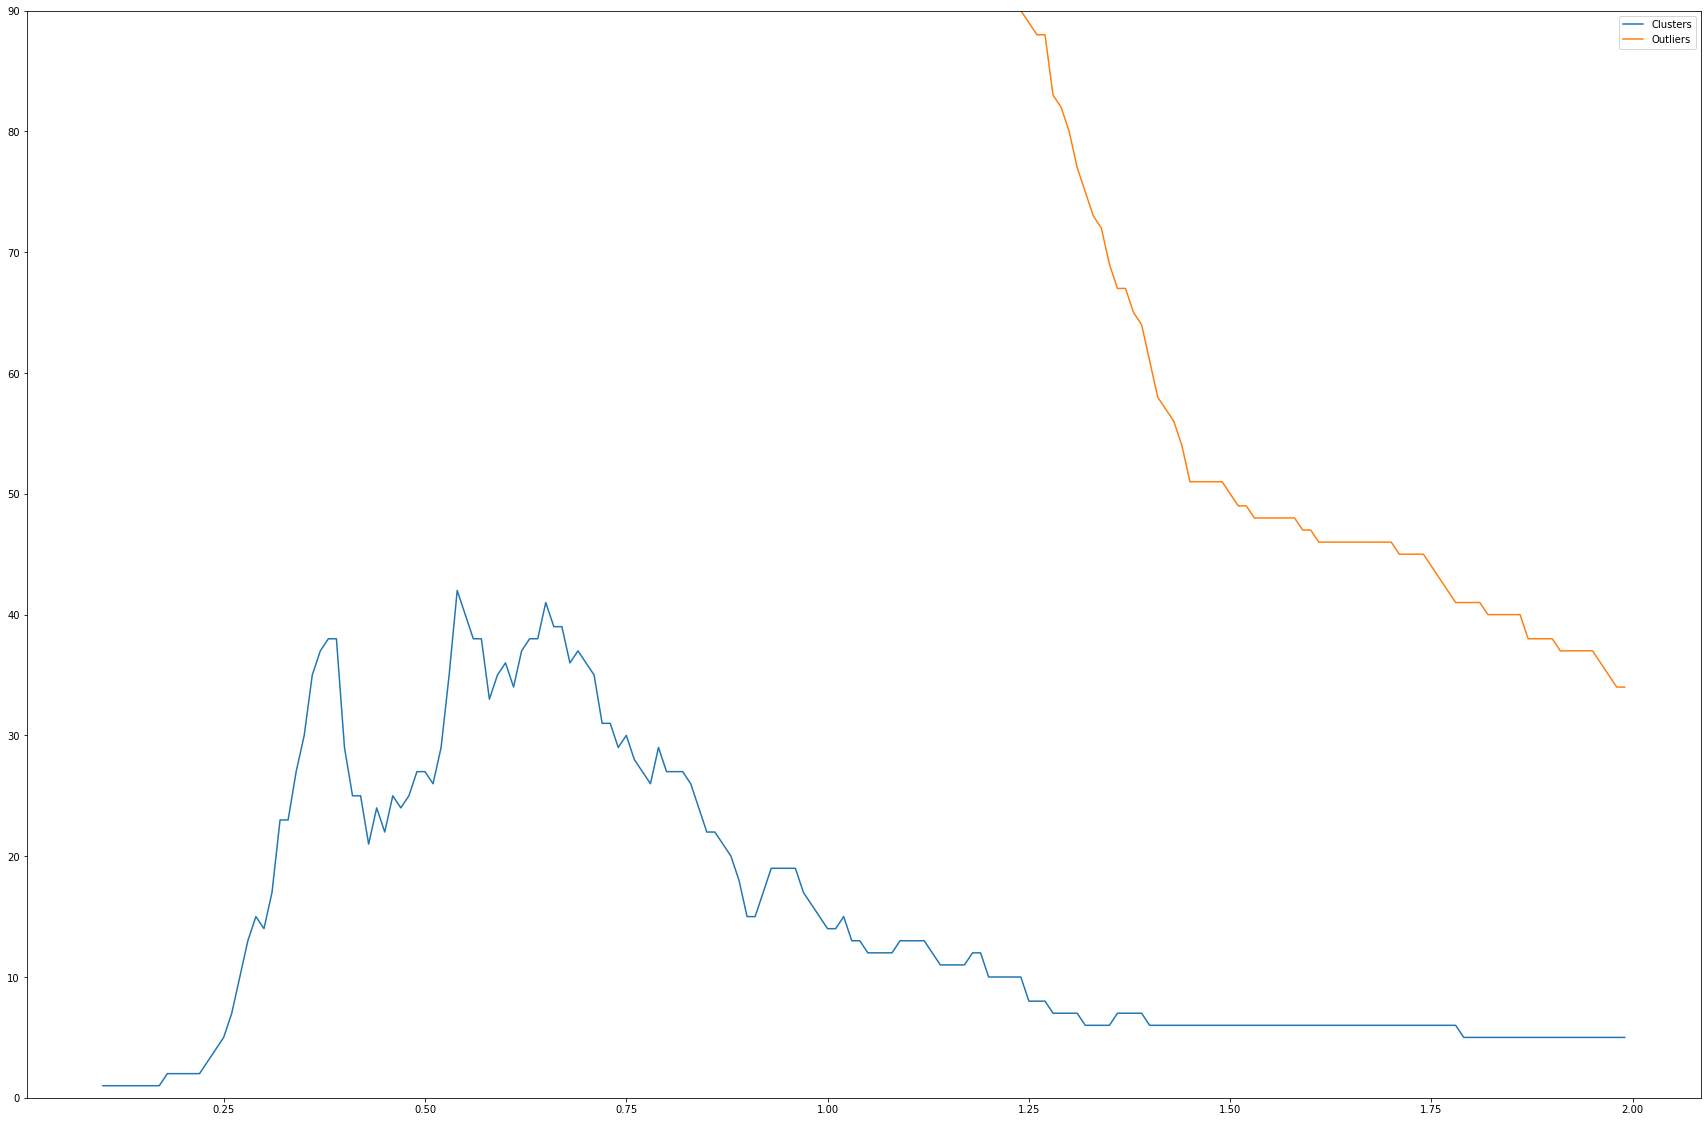

In [62]:
plt.figure(figsize=(30, 20));
plt.plot(rango, num_clusters, label="Clusters");
plt.plot(rango, num_outliers, label="Outliers");
plt.ylim(top=90, bottom=0);
plt.legend();

In [63]:
clustering = DBSCAN(eps=1.5, min_samples=2, n_jobs=-1).fit(espectros_latentes)
labels = np.unique(clustering.labels_, return_counts=True)
labels

(array([-1,  0,  1,  2,  3,  4]), array([  50, 1501,    2,    6,    2,    2]))

Como en todos los experimentos realizados con DBSCAN, salen un número bajo de clusters (sin permitir que se dispare el número de outliers), pero todas las muestras caen en uno solo de los clusters, excepto 2 o 3 que caen en los otros.

Es decir, con DBSCAN no obtenemos clusters significativos, pero podemos sacar outliers con cierta facilidad. Otra cosa es que estos outliers sean interesantes, lo  que deberemos exponer al juicio del IAC.

#### Visualización de clusters resultantes

Vamos a dibujar los 10 primeros ejemplos dentro de cada cluster, representado primero los espectros latentes, luego los estandarizados y por último los originales sin estandarizar.

Lo haremos igual para cada cluster.

In [64]:
clusters = []
for i in range(-1,len(labels[0]), 1): # Empezamos en -1 para coger también los outliers, en el índice 0 del array labels
    clusters.append(np.where(clustering.labels_==i))

In [69]:
# Función para representar las tres gráficas de varios elementos de un cluster

def grafica_cluster(cluster, num_graf=10):
    print("Cluster: ", cluster)
    
    plt.figure(figsize=(20, 50))

    # Si el cluster tiene menos de 10 unidades, dará error al intentar representarlo. Corregimos esto.
    if len(clusters[cluster][0]) < num_graf:
        num_graf2 = len(clusters[cluster][0])
    else:
        num_graf2 = num_graf
    
    for n in range(num_graf2):
        # Gráficas de los espectros latentes
        ax = plt.subplot(num_graf2*3, 1, n+1)
        plt.plot(espectros_latentes[clusters[cluster][0][n]])
        plt.title("Latentes")
        # Gráficas de los espectros originales estandarizados
        bx = plt.subplot(num_graf2*3, 1, (n+1+num_graf2))
        espectros_scaled.iloc[clusters[cluster][0][n]].plot()
        plt.title("Estandarizados")
        # Gráficas de los espectros originales sin estandarizar
        cx = plt.subplot(num_graf2*3, 1, (n+1+(num_graf2*2)))
        data.iloc[clusters[cluster][0][n]].plot()
        plt.title("Sin estandarizar")
        plt.savefig('espectros.png')
    

Cluster:  0


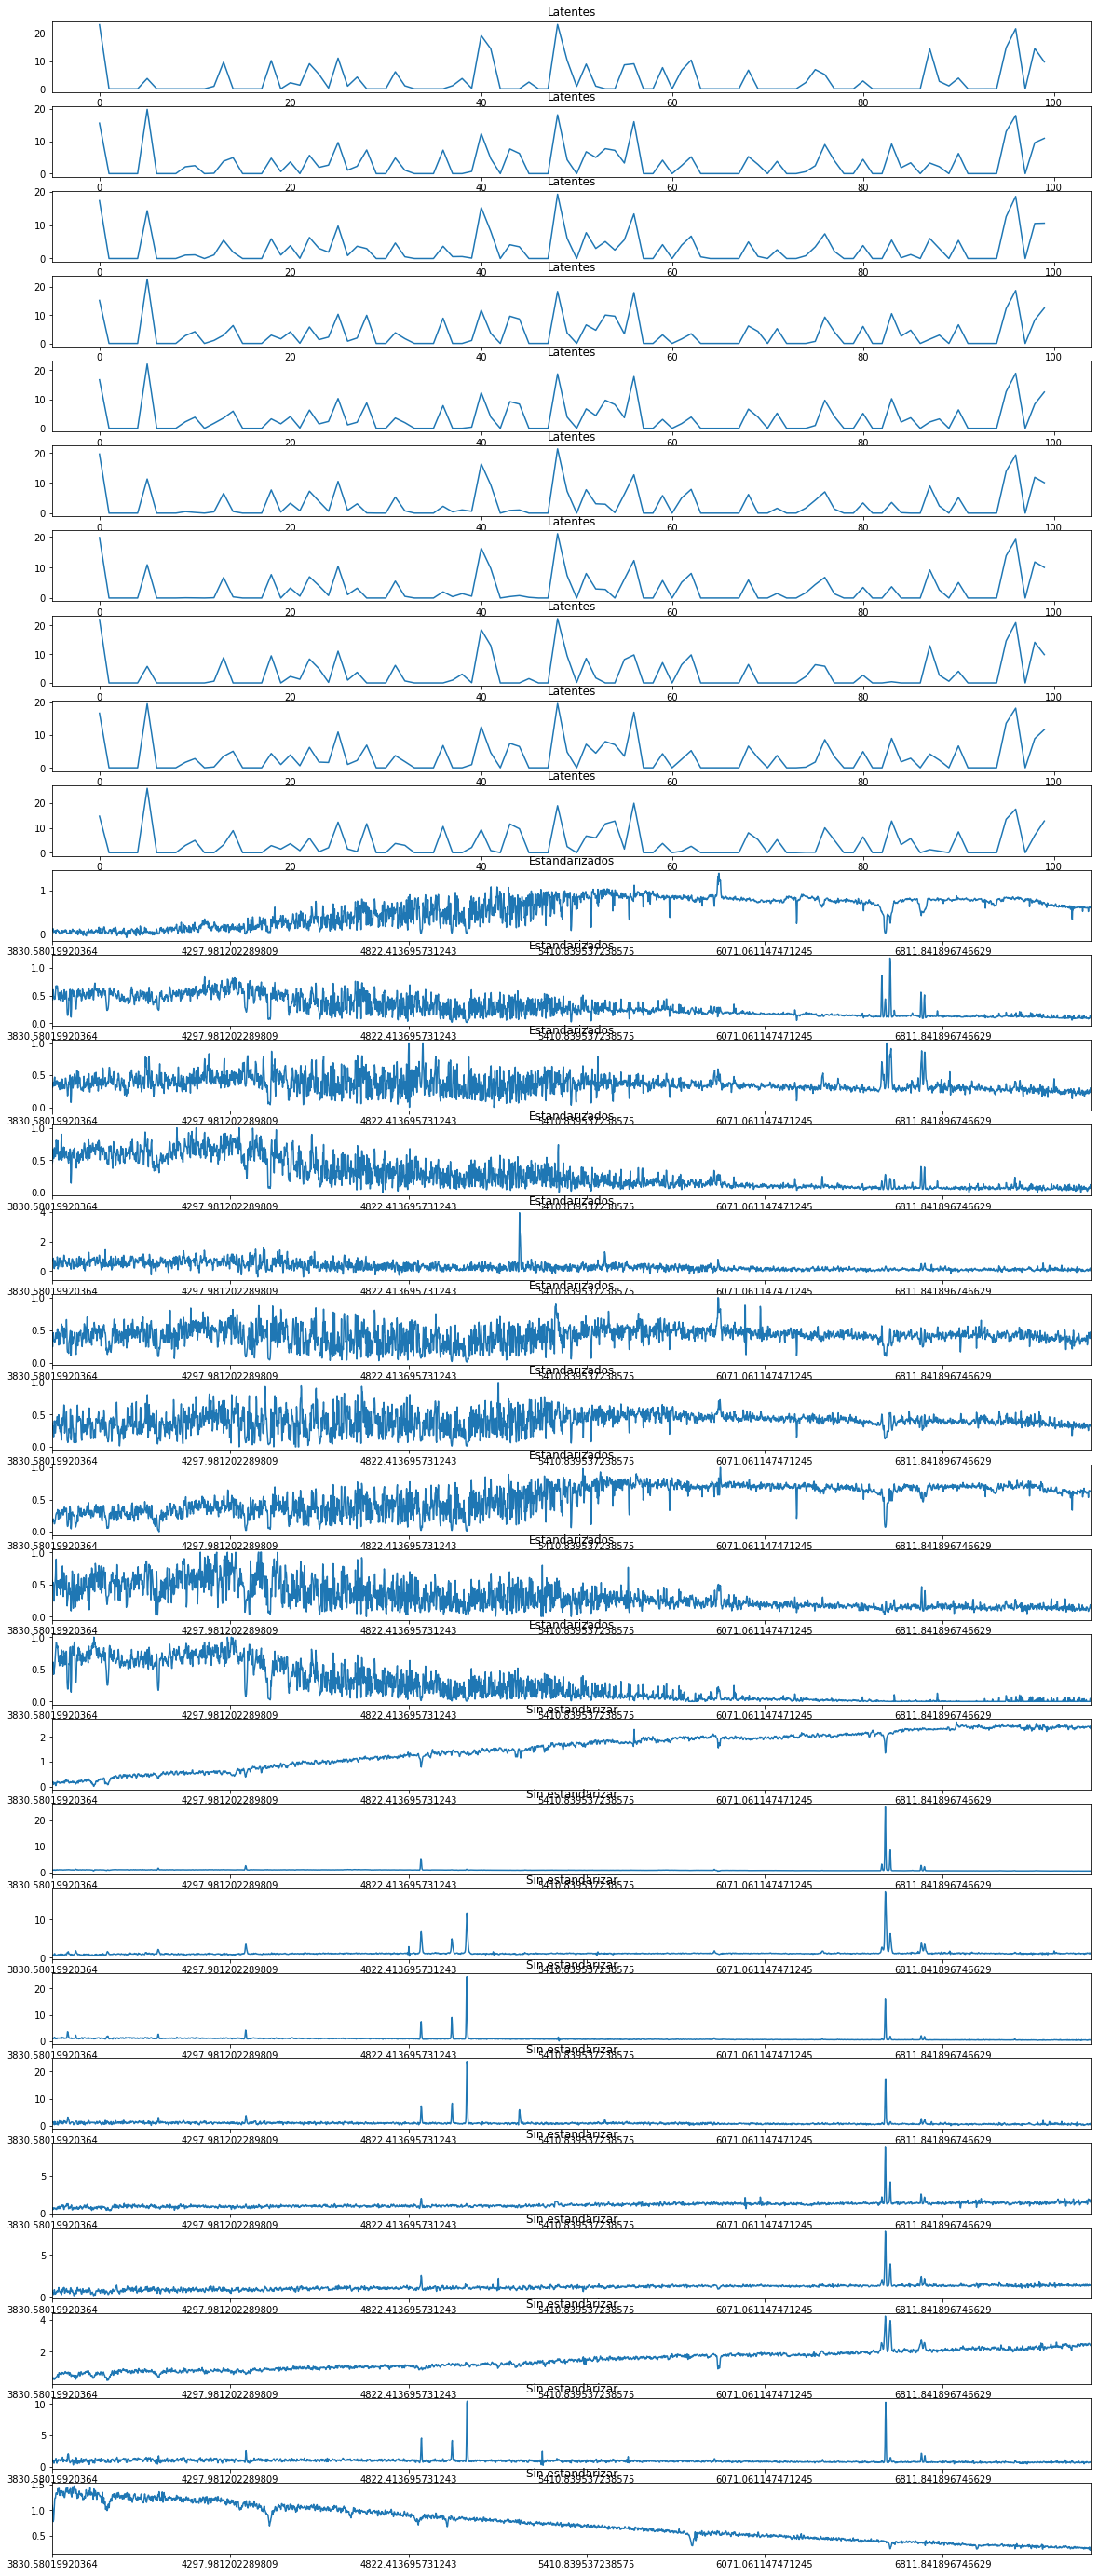

In [70]:
# Outliers (label = -1, index en array "cluster" = 0)
grafica_cluster(0)

Cluster:  1


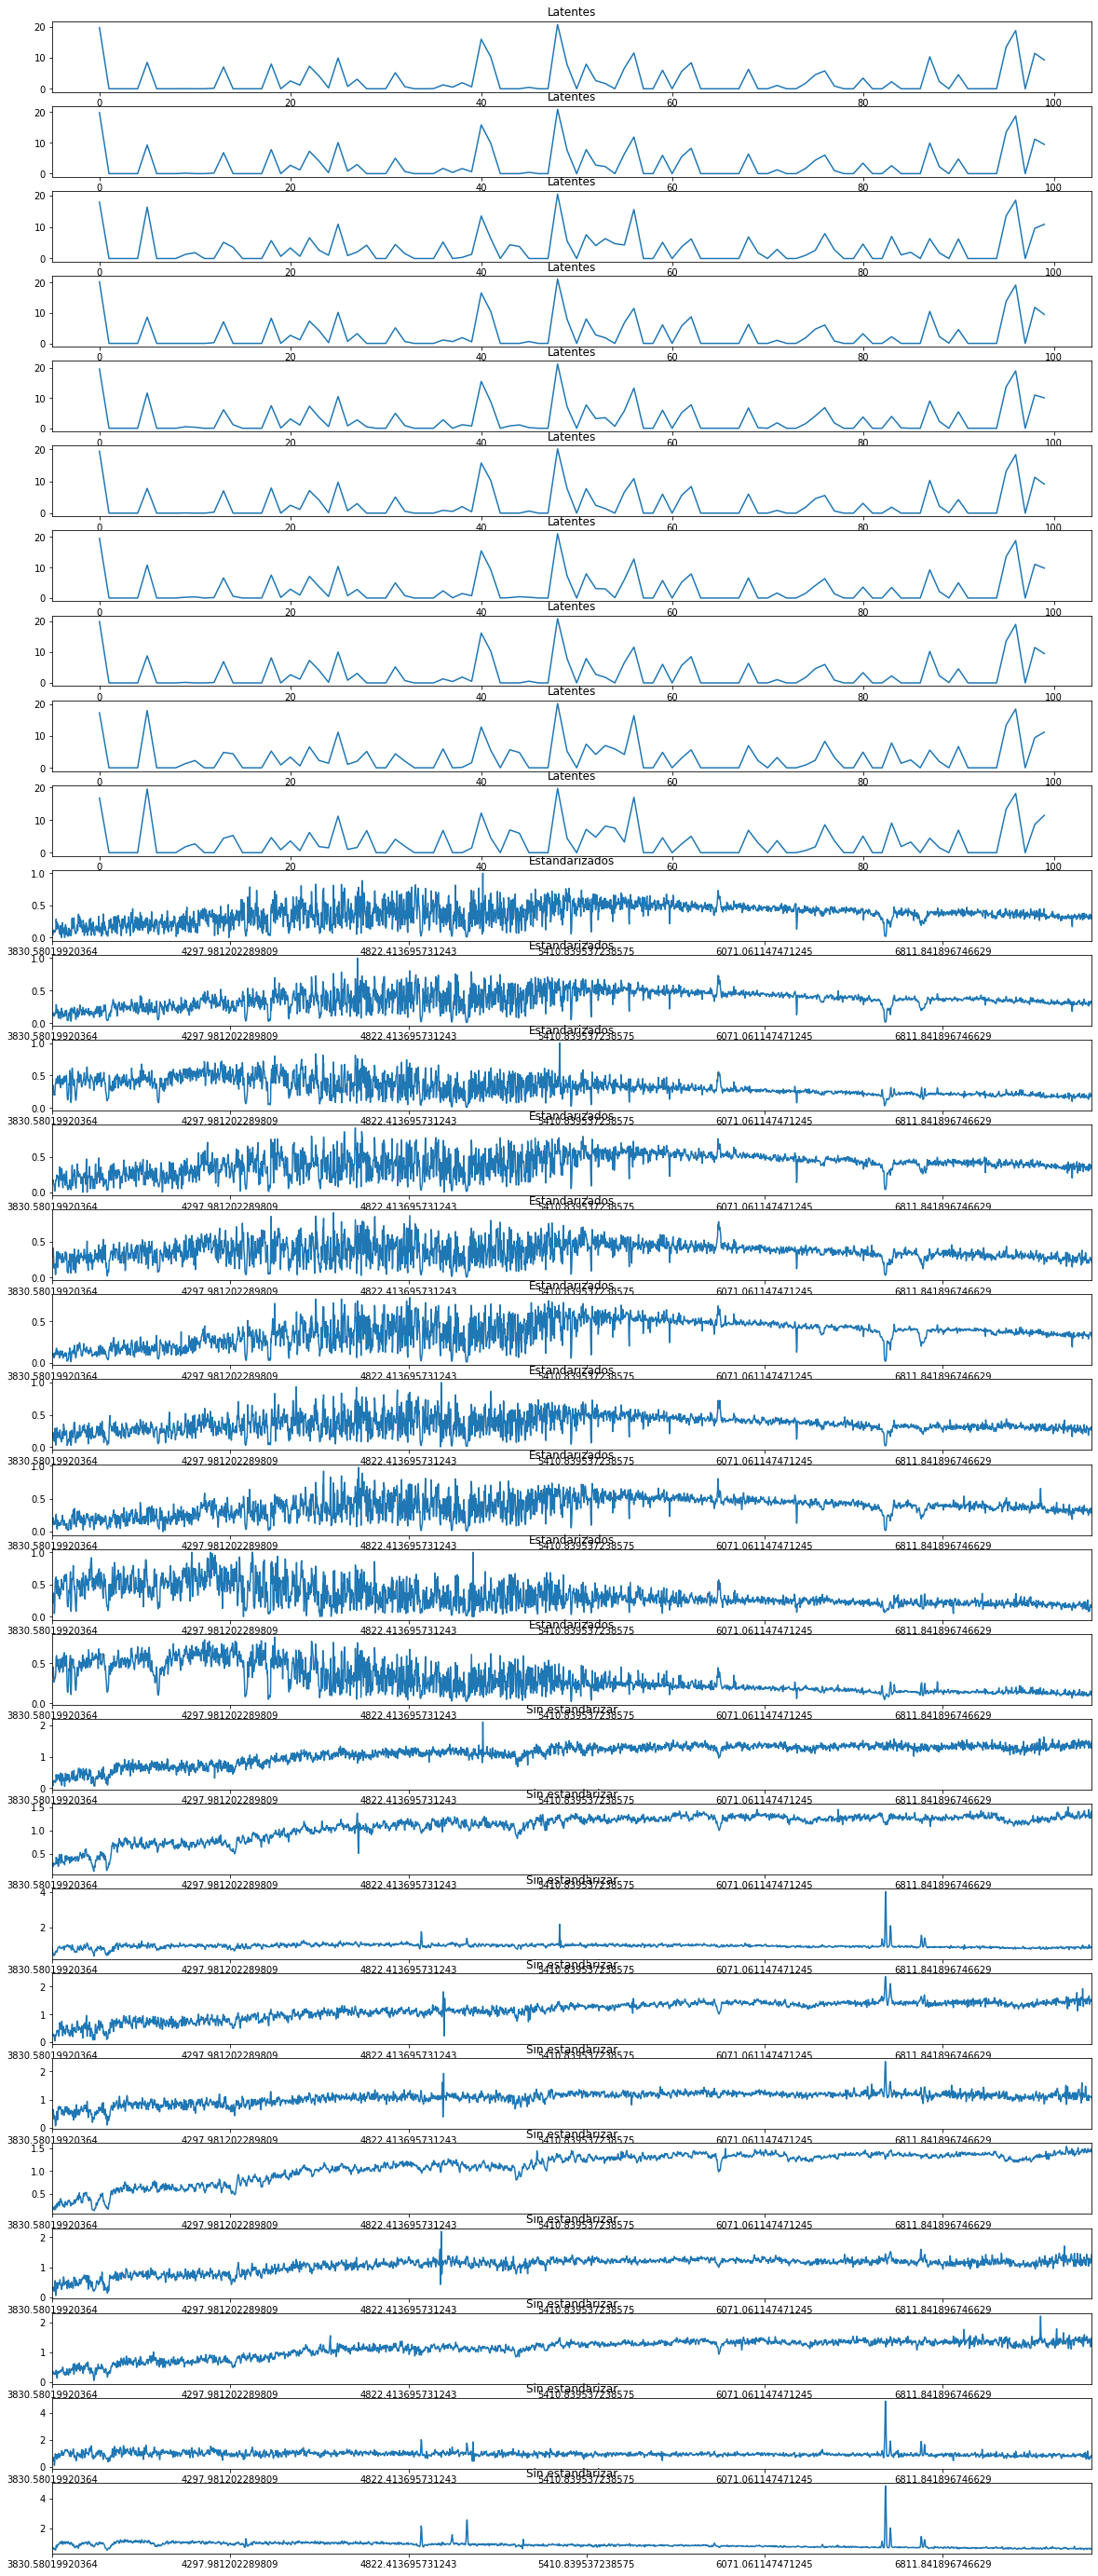

In [71]:
# Grupo label = 0 (index 1)
grafica_cluster(1)

Cluster:  2


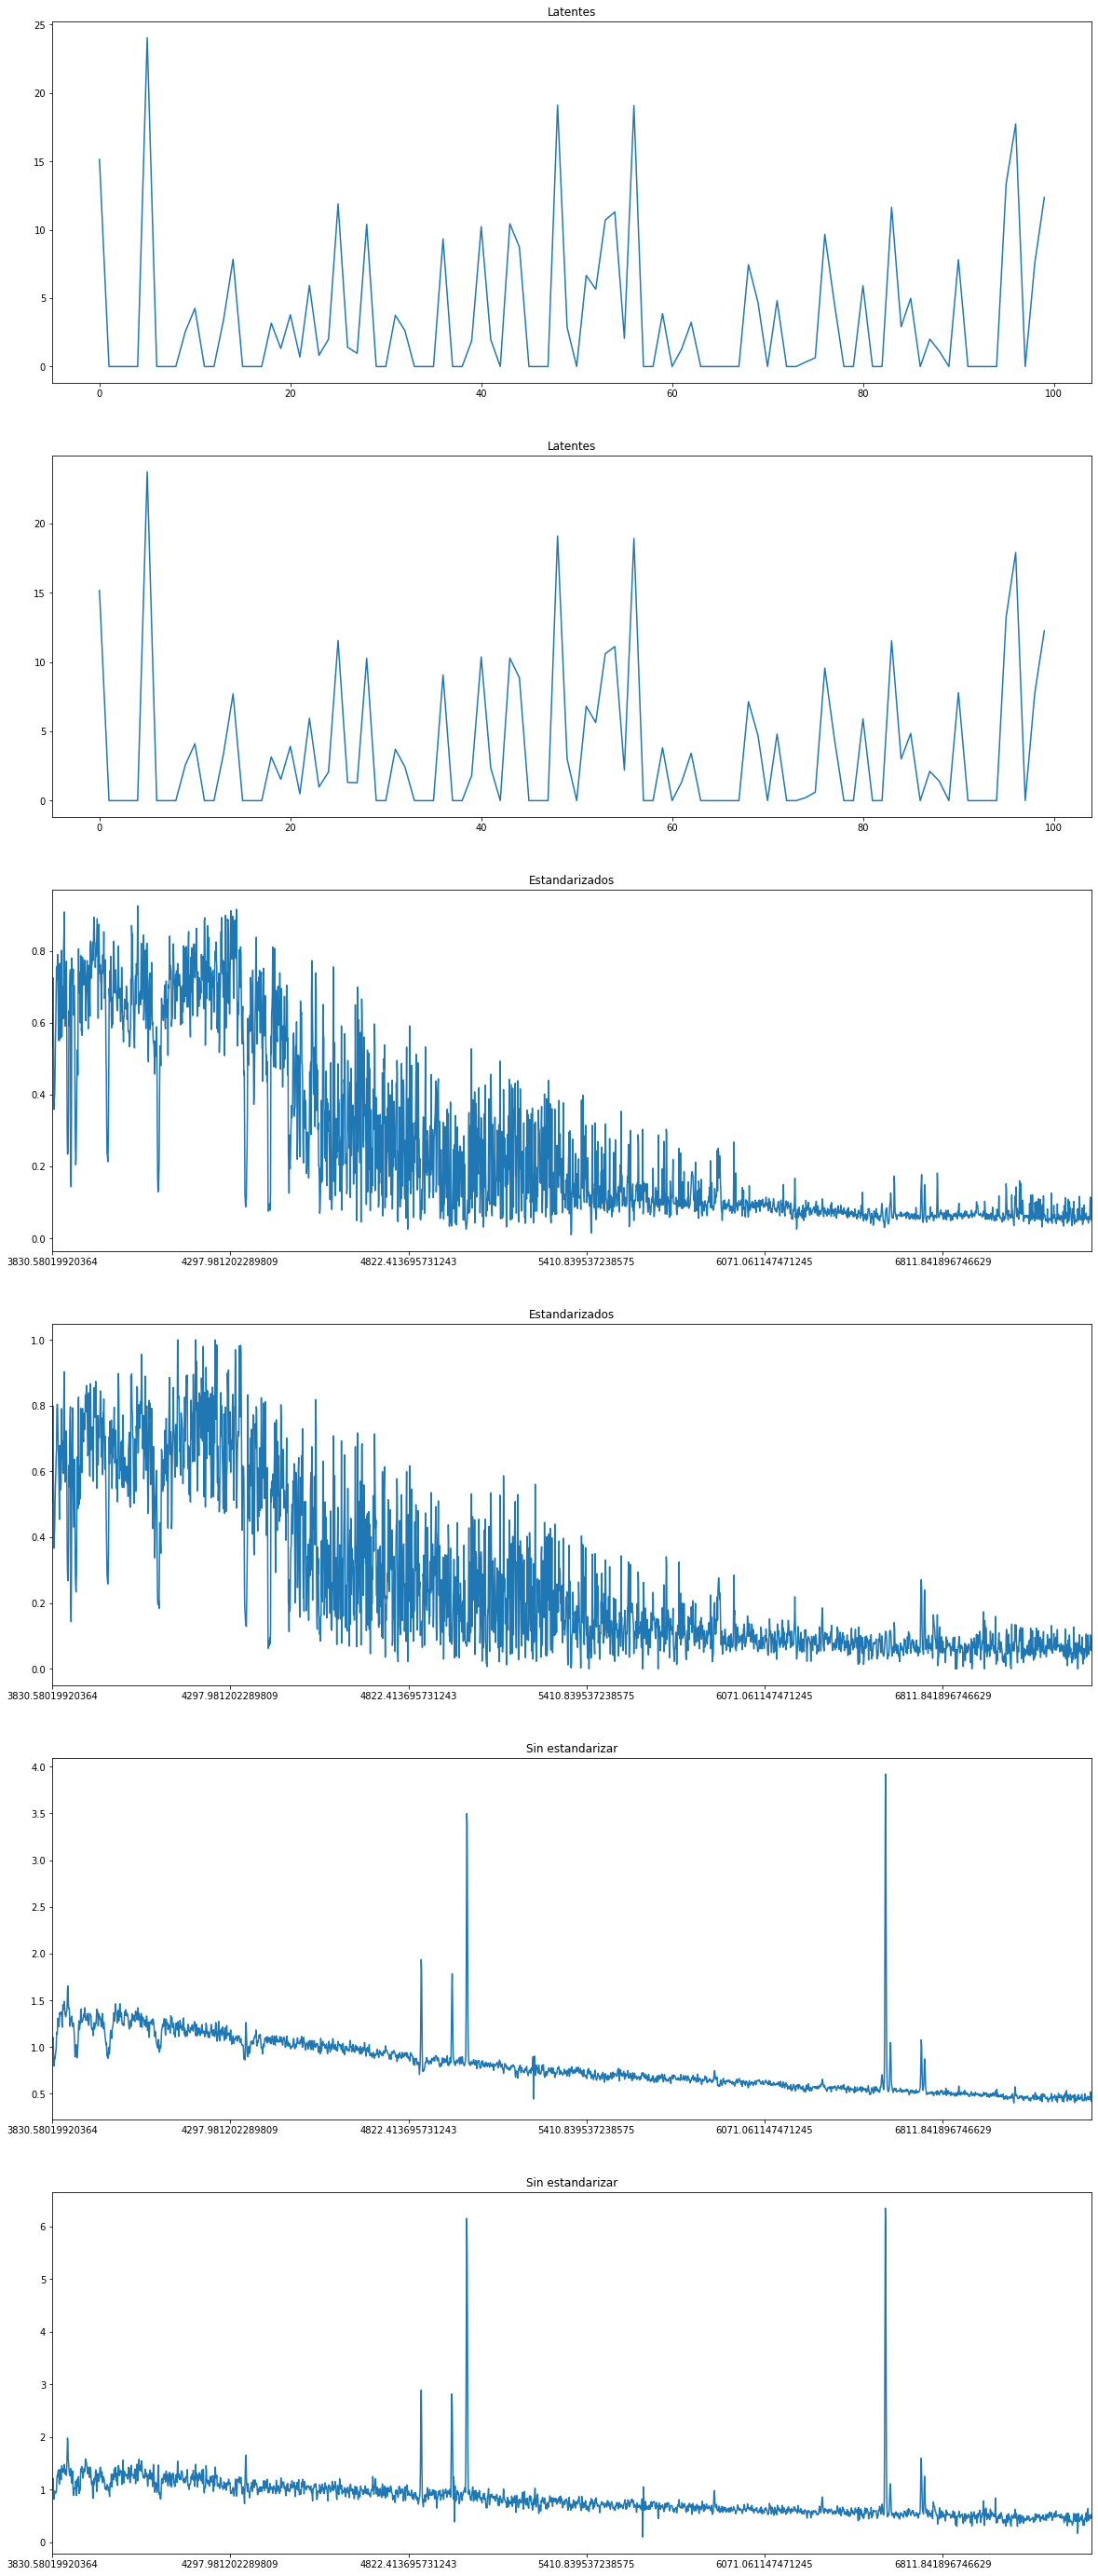

In [72]:
# Grupo label = 1 (index 2)
grafica_cluster(2)

Cluster:  3


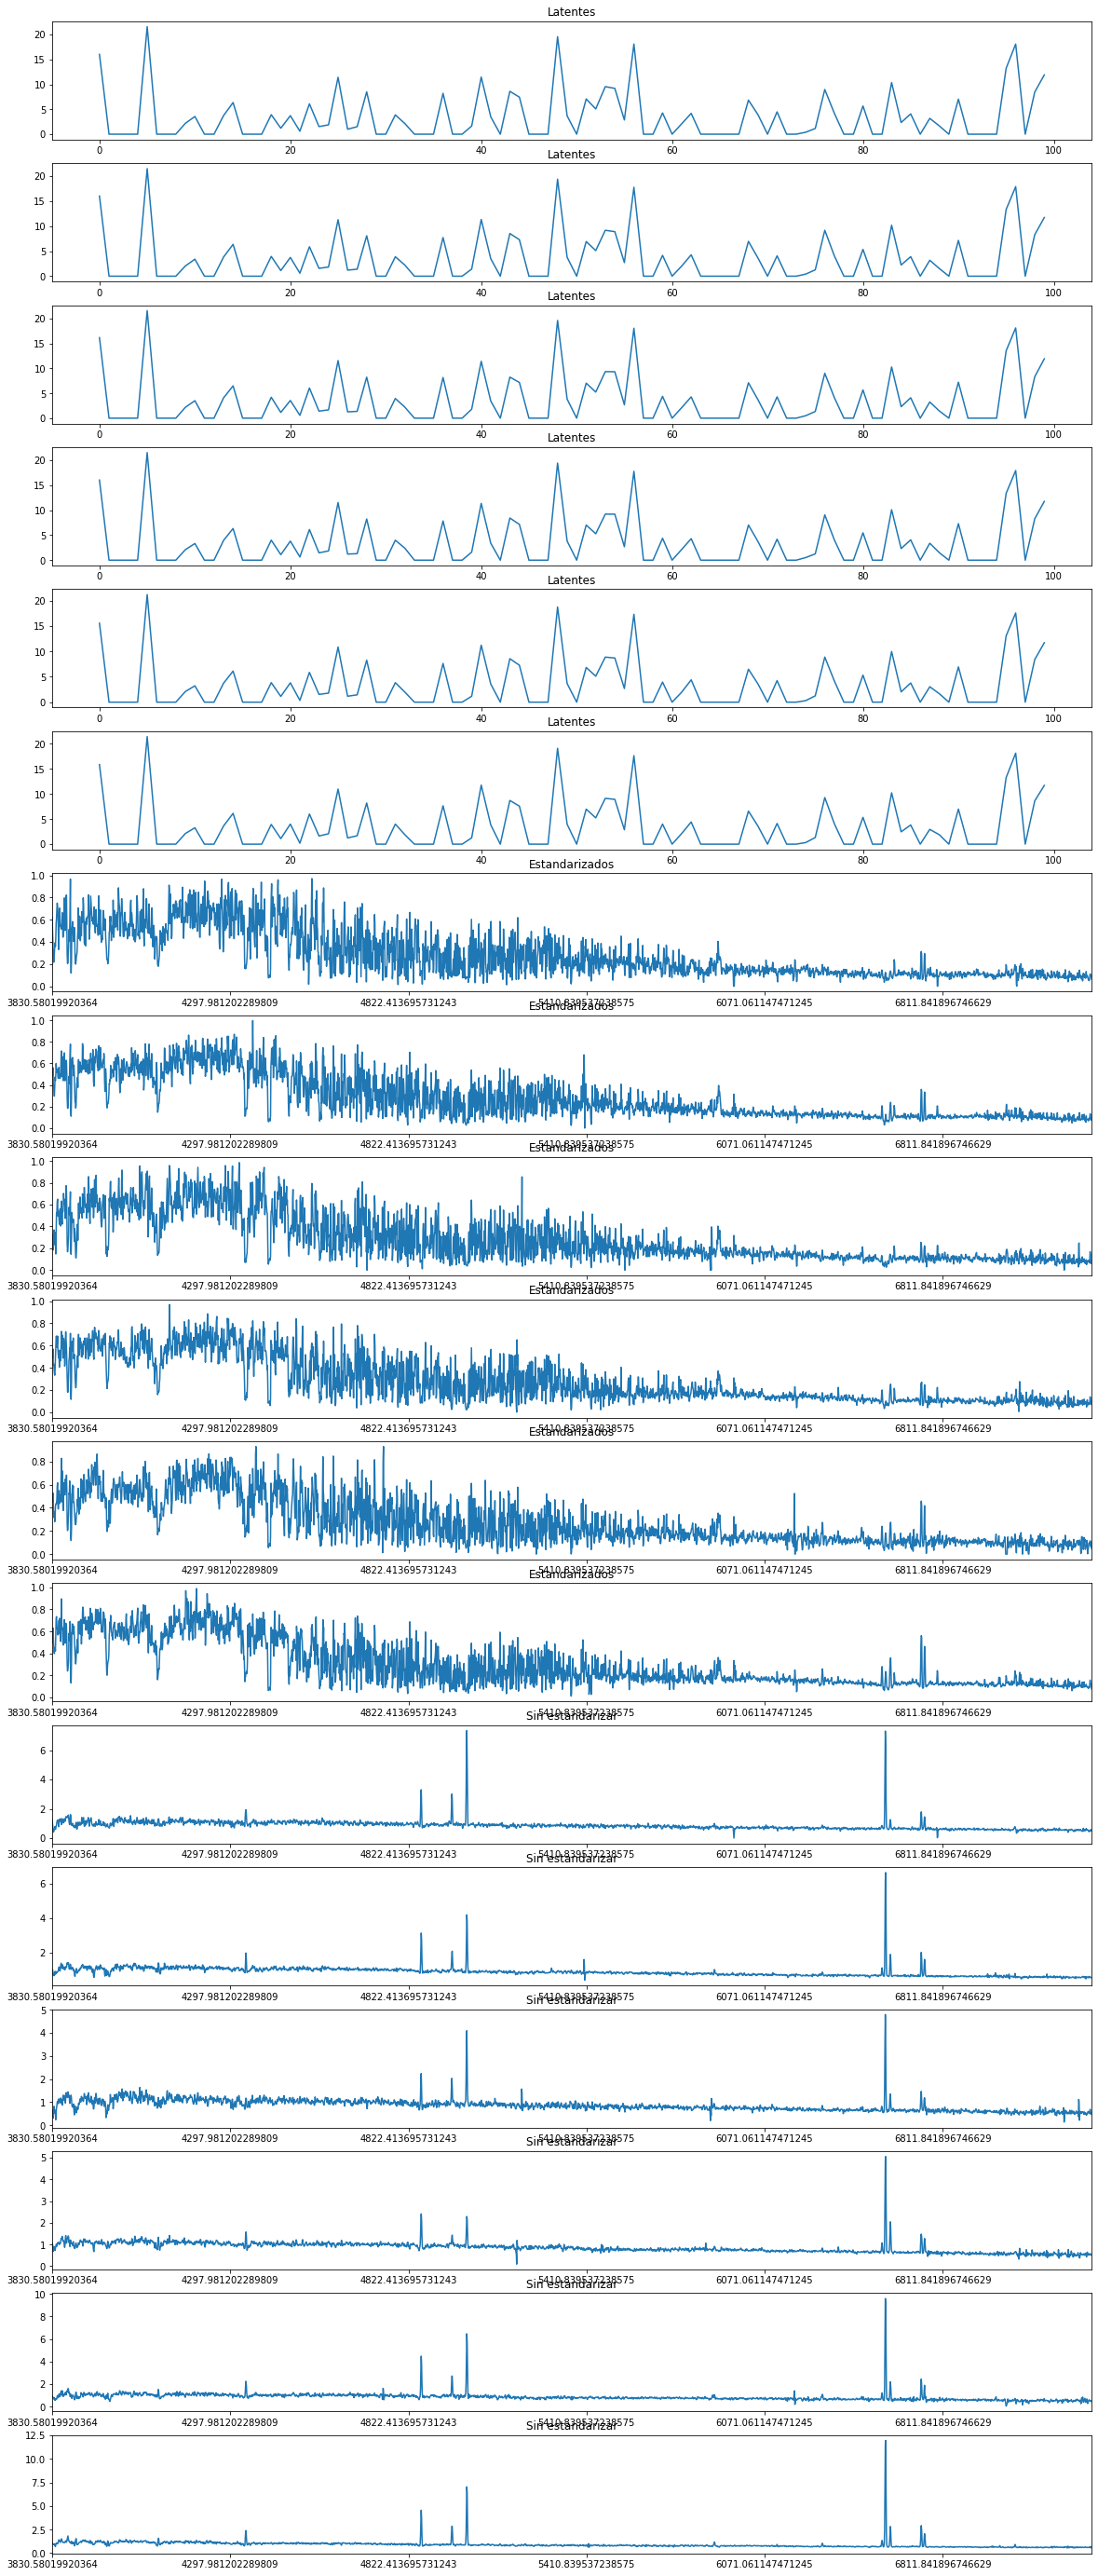

In [74]:
# Grupo label = 2 (index 3)
grafica_cluster(3)

Cluster:  4


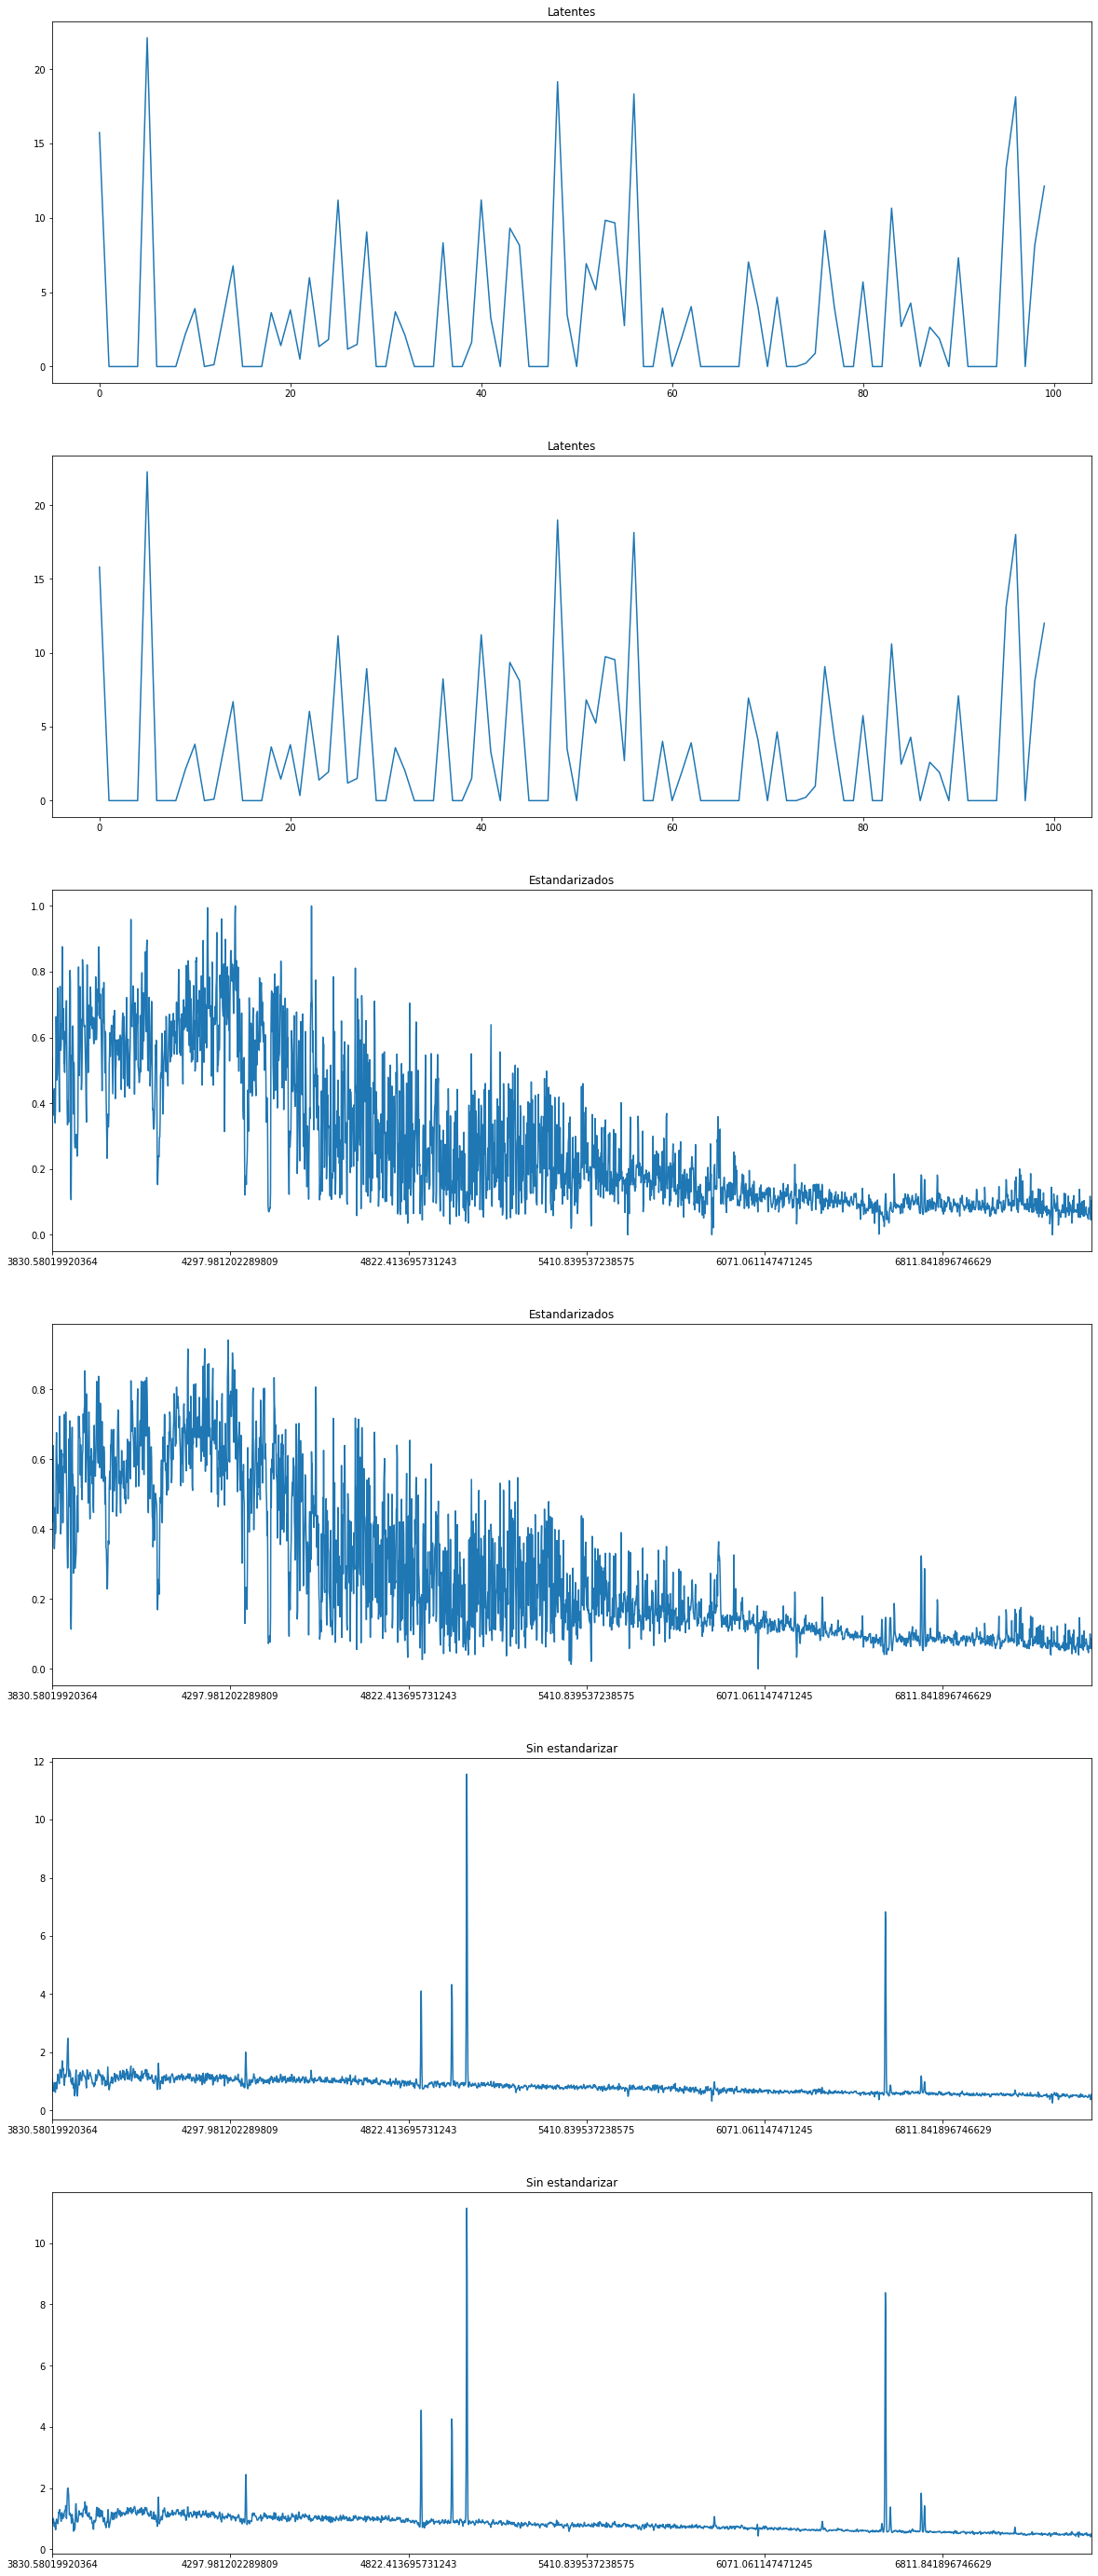

In [75]:
# Grupo label = 3 (index 4)
grafica_cluster(4)

Cluster:  5


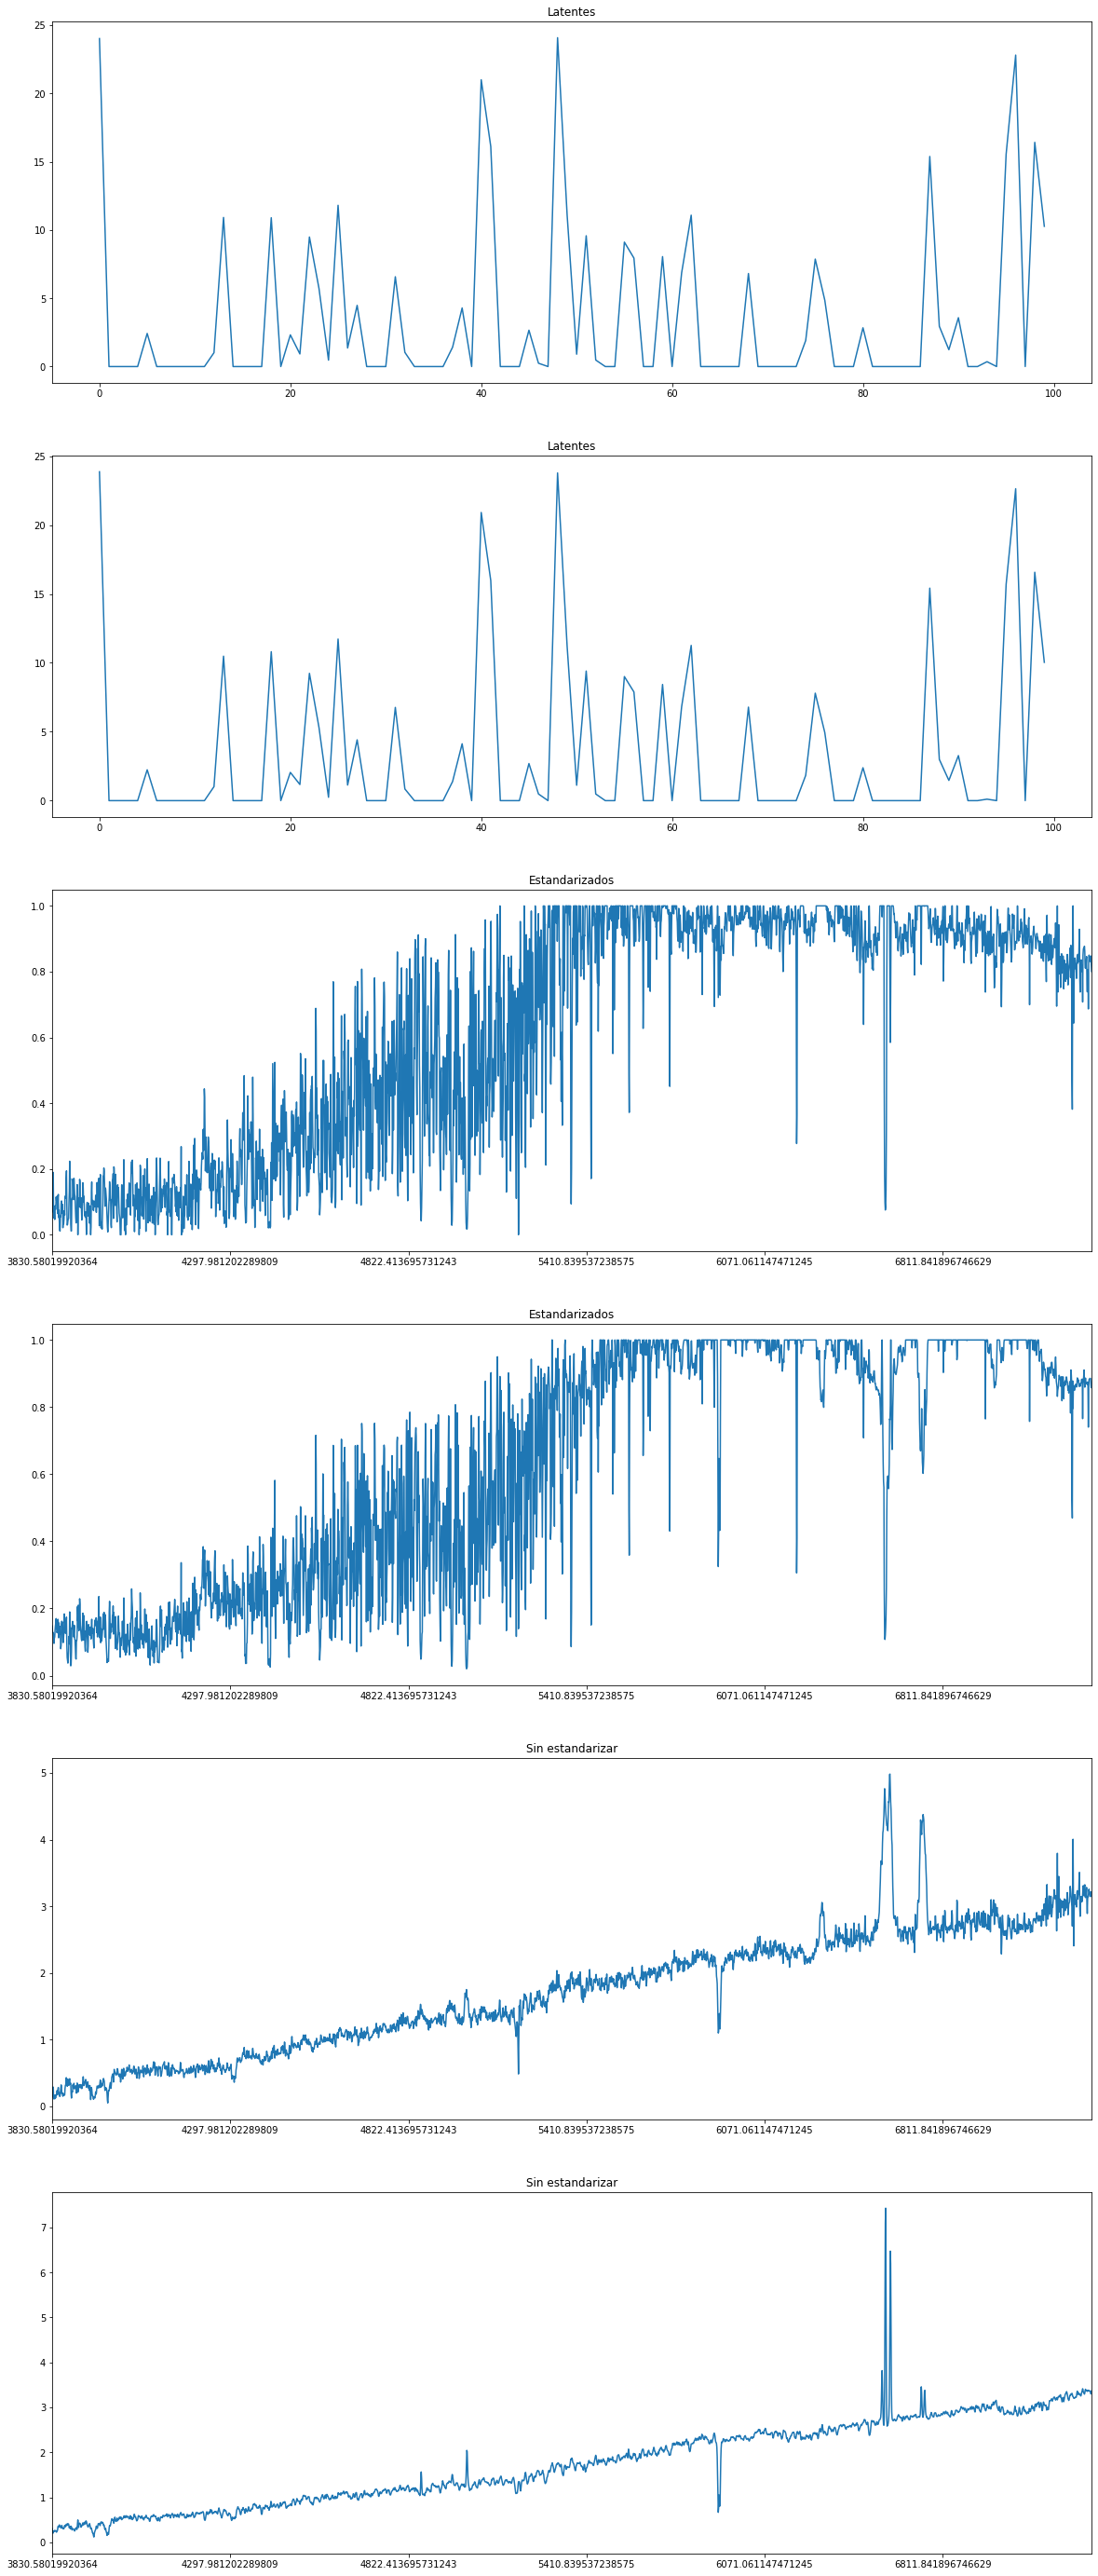

In [76]:
# Grupo label = 4 (index 5)
grafica_cluster(5)

## 2. Gaussian Mixture

Vamos a estudiar otros algoritmos de clustering. Primero vemos el número de clusters óptimo. Usaremos Silhouette method con Gaussian Mixture.

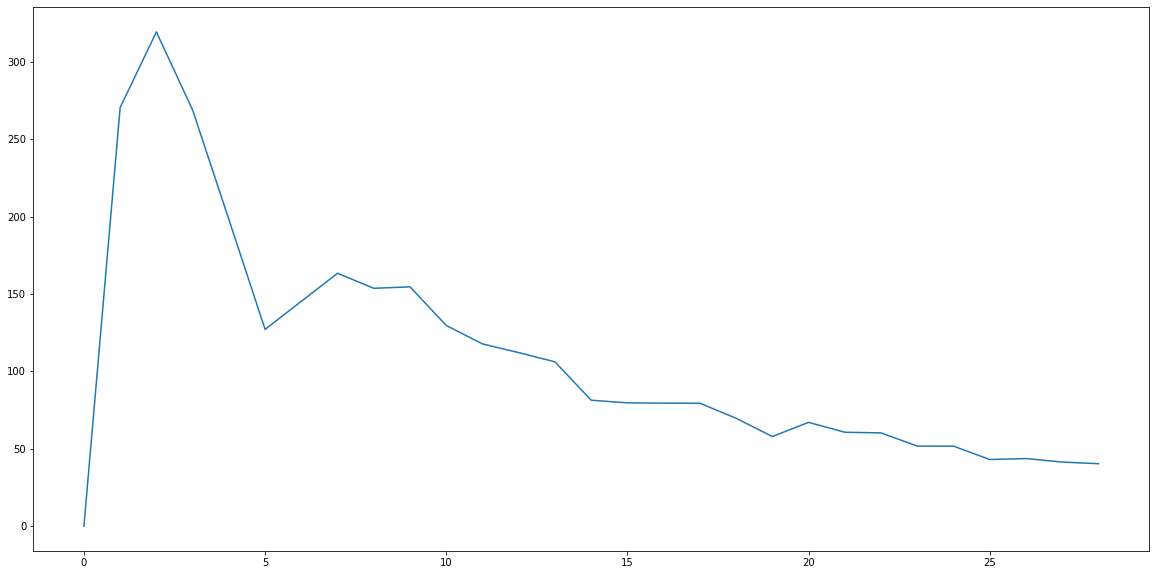

In [77]:
# Este es un vacile previo sin utilidad real. Mi intención era investigar el número de elementos contenidos
# en cada cluster, variando el número de éstos de 1 a 30, con GMM. Y más concretamente, quería investigar la
# desviación típica de cada asignación. Esperaba que la desviación se fuera incrementando, es decir, que cada vez
# se fueran concentrando más asignaciones a un solo cluster, que es lo que pasaba con DBSCAN. En cambio, sucede
# todo lo contrario, la desviación típica disminuye, lo que significa que el reparto hace que los clusters 
# tengan cada vez números más parecidos de elementos. 

num_asig_seguras = []
desviacion = []
historial = []
for i in range(1, 30, 1):
    np.random.seed(21)
    clustering = GaussianMixture(n_components=i)
    clustering.fit(espectros_latentes)

    labels = clustering.predict(espectros_latentes)
    unique_labels = np.unique(labels, return_counts=True)[1]
    historial.append(unique_labels)
    desviacion.append(unique_labels.std())
    
plt.figure(figsize=(20, 10));     
plt.plot(desviacion);

Utilizaremos Silhouette Method para la determinación del número óptimo de clusters, usando GMM como algoritmo de clustering.

For n_clusters = 2 the average silhouette_score is : 0.607328
For n_clusters = 3 the average silhouette_score is : 0.40587613
For n_clusters = 4 the average silhouette_score is : 0.29836836
For n_clusters = 5 the average silhouette_score is : 0.21732387
For n_clusters = 6 the average silhouette_score is : 0.3091453
For n_clusters = 7 the average silhouette_score is : 0.24364148
For n_clusters = 8 the average silhouette_score is : 0.33536717
For n_clusters = 9 the average silhouette_score is : 0.3191511
For n_clusters = 10 the average silhouette_score is : 0.32185197
For n_clusters = 11 the average silhouette_score is : 0.3383935
For n_clusters = 12 the average silhouette_score is : 0.25836274
For n_clusters = 13 the average silhouette_score is : 0.23526277
For n_clusters = 14 the average silhouette_score is : 0.25567153
For n_clusters = 15 the average silhouette_score is : 0.2791587
For n_clusters = 16 the average silhouette_score is : 0.27774665
For n_clusters = 17 the average silhoue

/home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


For n_clusters = 22 the average silhouette_score is : 0.26836285


/home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


For n_clusters = 23 the average silhouette_score is : 0.2652336


/home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


For n_clusters = 24 the average silhouette_score is : 0.25507632


/home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


For n_clusters = 25 the average silhouette_score is : 0.24654126


/home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


For n_clusters = 26 the average silhouette_score is : 0.24696971


/home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


For n_clusters = 27 the average silhouette_score is : 0.24631582


/home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


For n_clusters = 28 the average silhouette_score is : 0.2399804


/home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


For n_clusters = 29 the average silhouette_score is : 0.24415709


/home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


For n_clusters = 30 the average silhouette_score is : 0.240608


/home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


For n_clusters = 31 the average silhouette_score is : 0.23989235


/home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


For n_clusters = 32 the average silhouette_score is : 0.24024262


/home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


For n_clusters = 33 the average silhouette_score is : 0.2299225


/home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


For n_clusters = 34 the average silhouette_score is : 0.2301701


/home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


For n_clusters = 35 the average silhouette_score is : 0.23188533


/home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


For n_clusters = 36 the average silhouette_score is : 0.23165669


/home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


For n_clusters = 37 the average silhouette_score is : 0.23042306


/home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


For n_clusters = 38 the average silhouette_score is : 0.22675635


/home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


For n_clusters = 39 the average silhouette_score is : 0.22229566


/home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


For n_clusters = 40 the average silhouette_score is : 0.22138017


/home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


For n_clusters = 41 the average silhouette_score is : 0.22335285


/home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


For n_clusters = 42 the average silhouette_score is : 0.22589144


/home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


For n_clusters = 43 the average silhouette_score is : 0.21670042


/home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


For n_clusters = 44 the average silhouette_score is : 0.21212563


/home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


For n_clusters = 45 the average silhouette_score is : 0.20942083


/home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


For n_clusters = 46 the average silhouette_score is : 0.20766495


/home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


For n_clusters = 47 the average silhouette_score is : 0.20416945


/home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


For n_clusters = 48 the average silhouette_score is : 0.20944718


/home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


For n_clusters = 49 the average silhouette_score is : 0.2053467


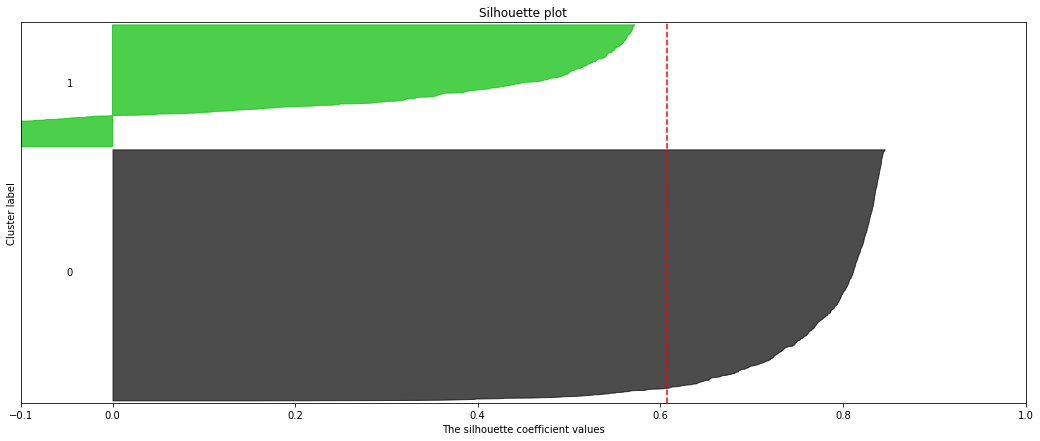

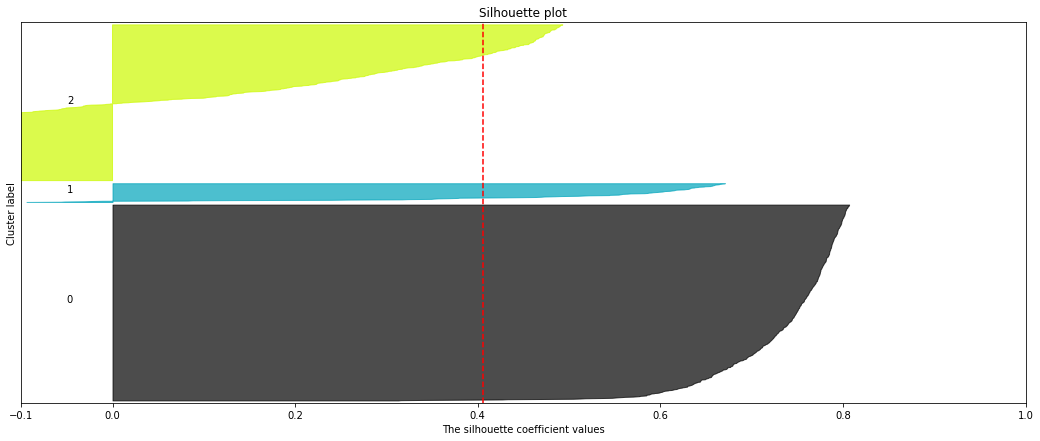

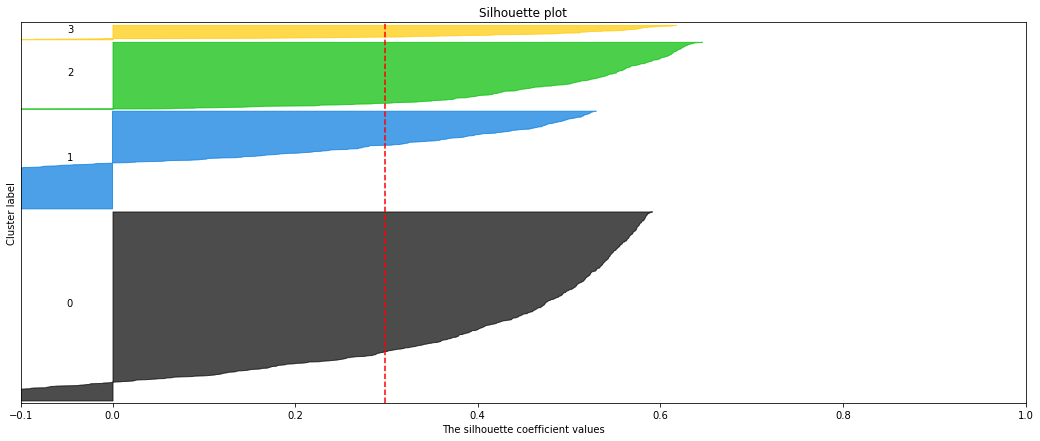

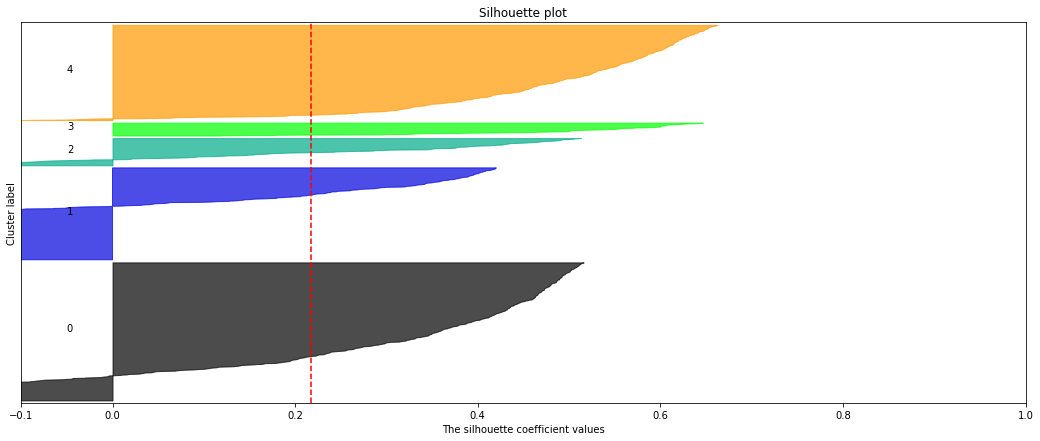

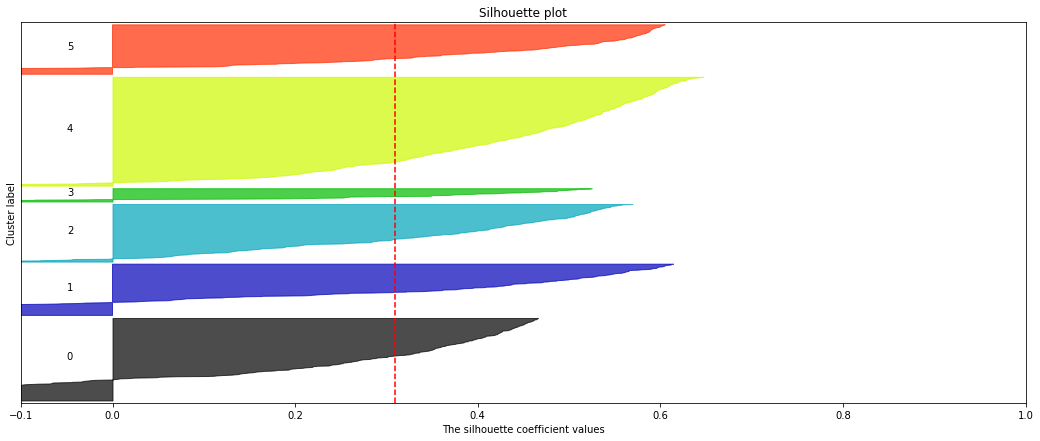

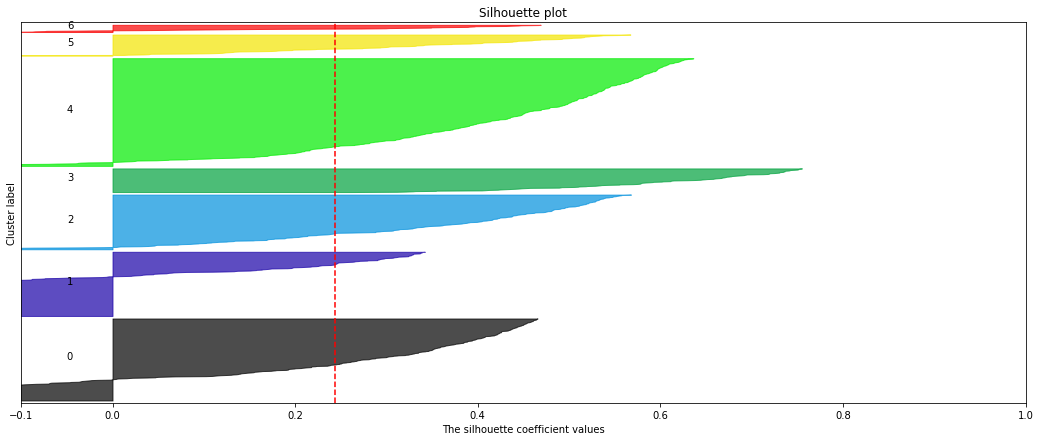

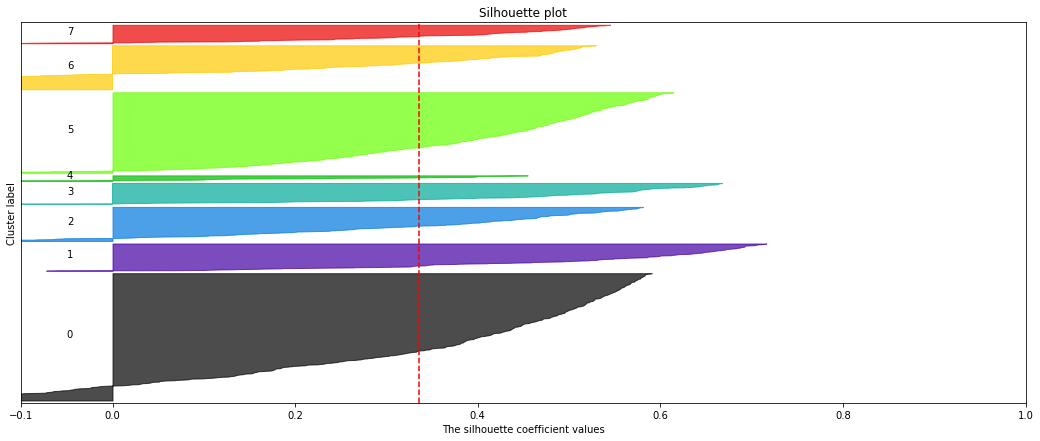

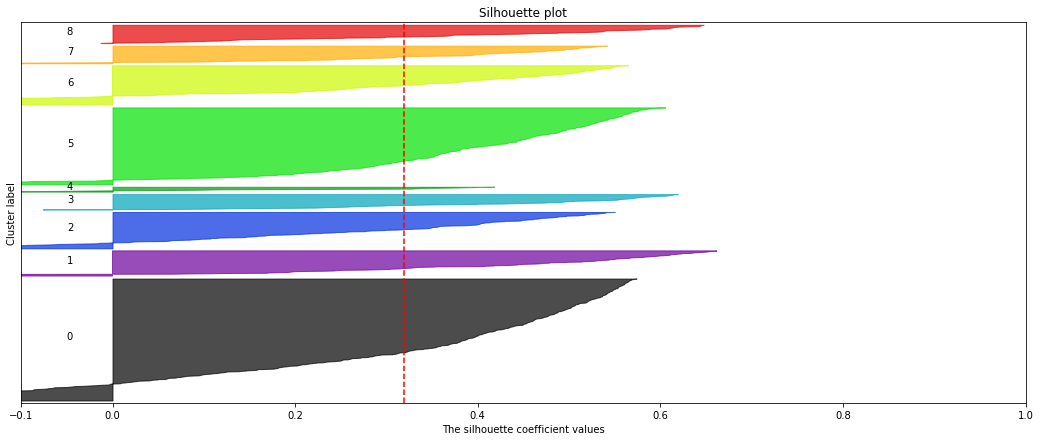

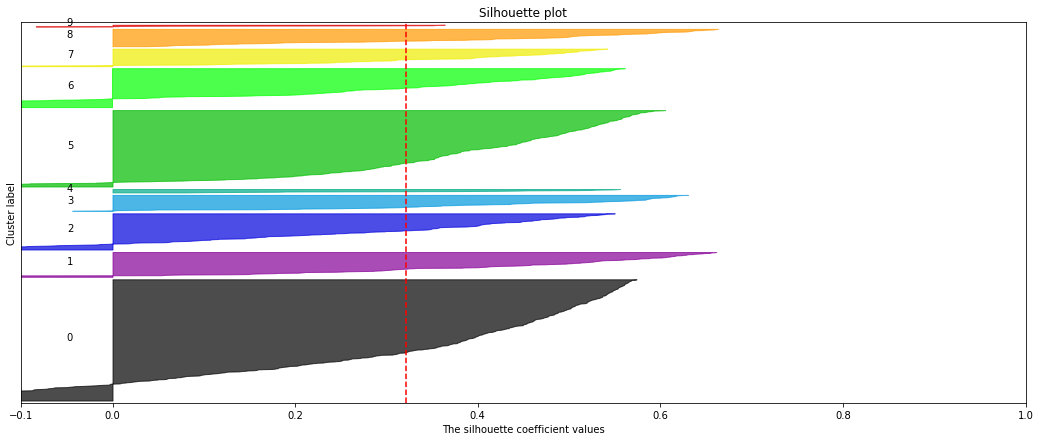

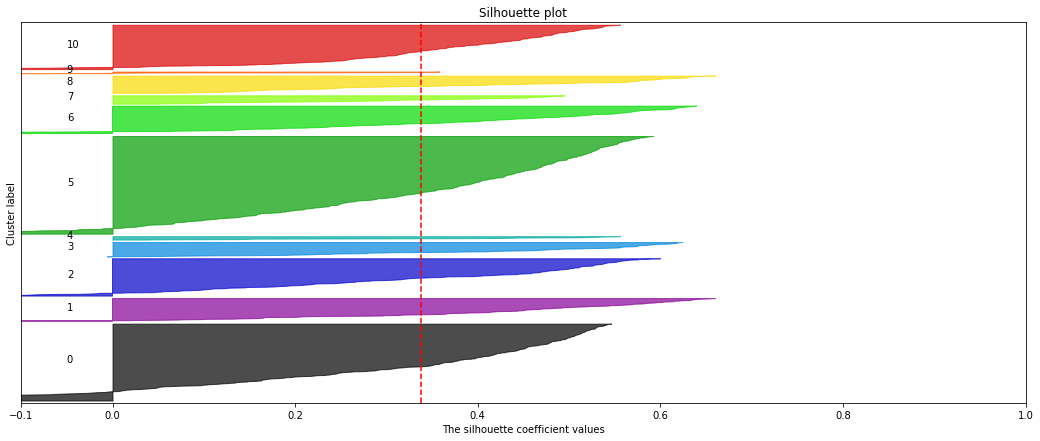

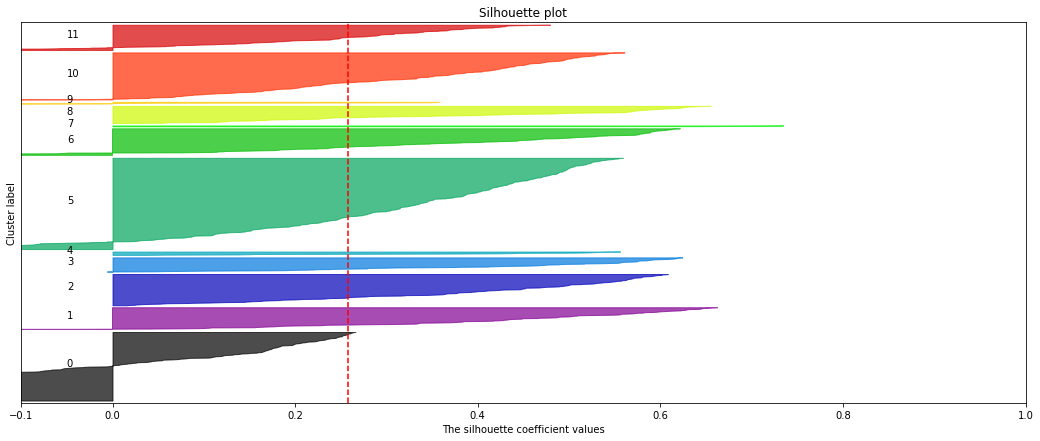

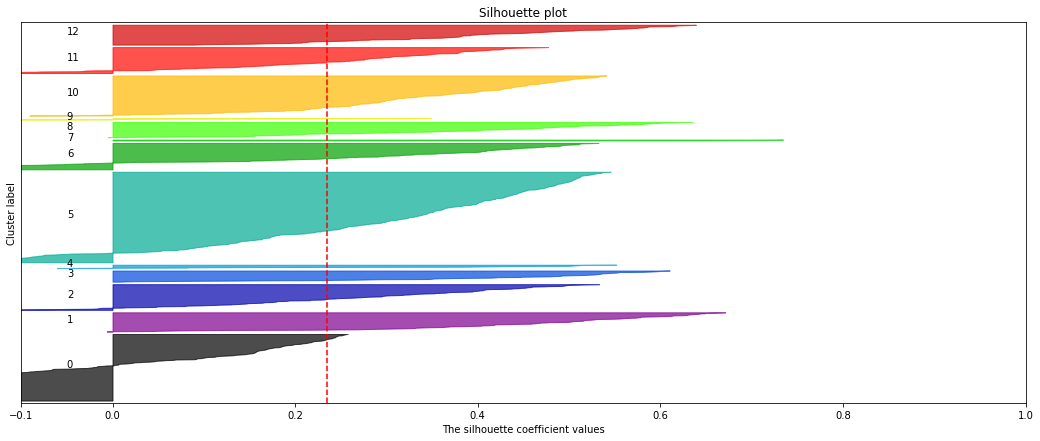

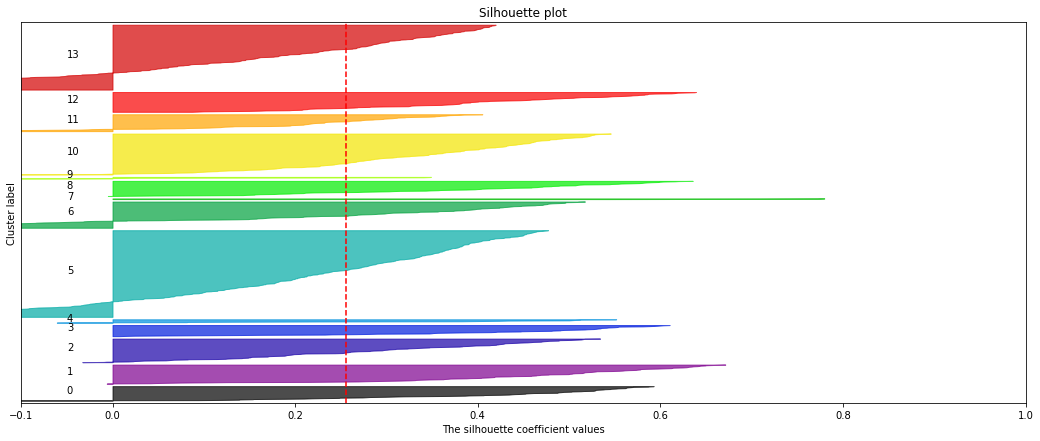

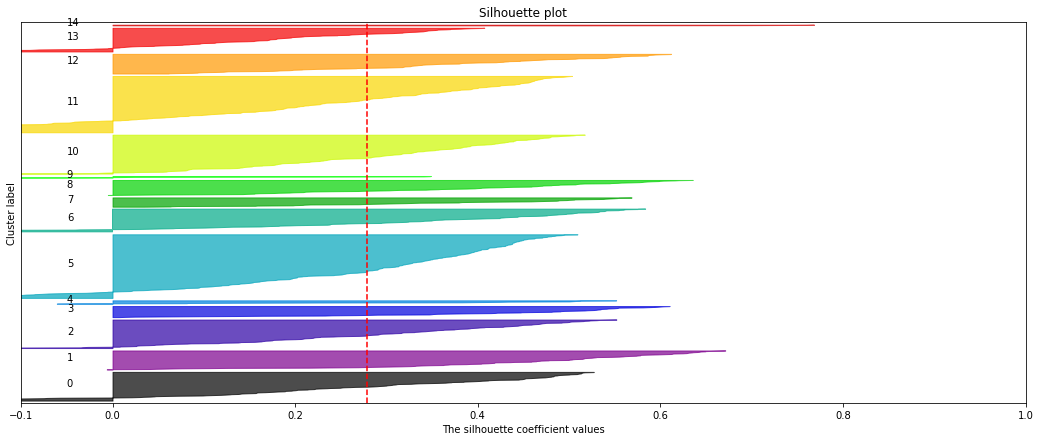

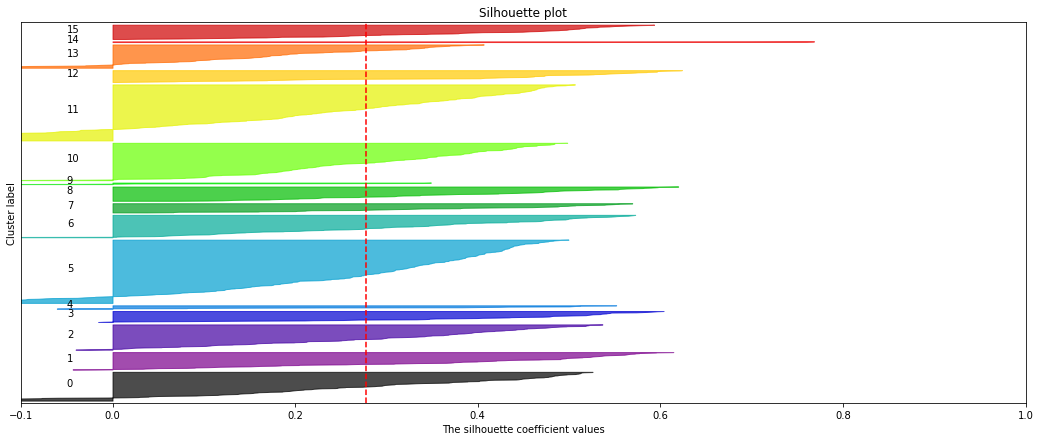

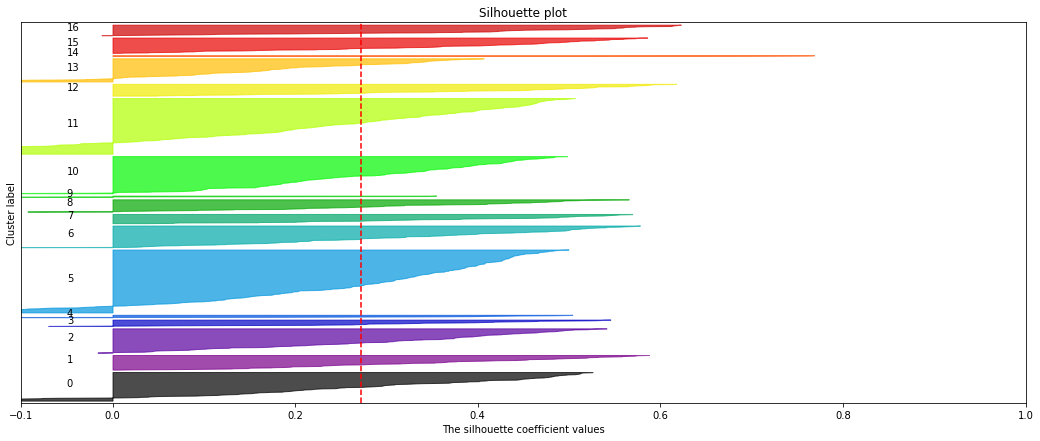

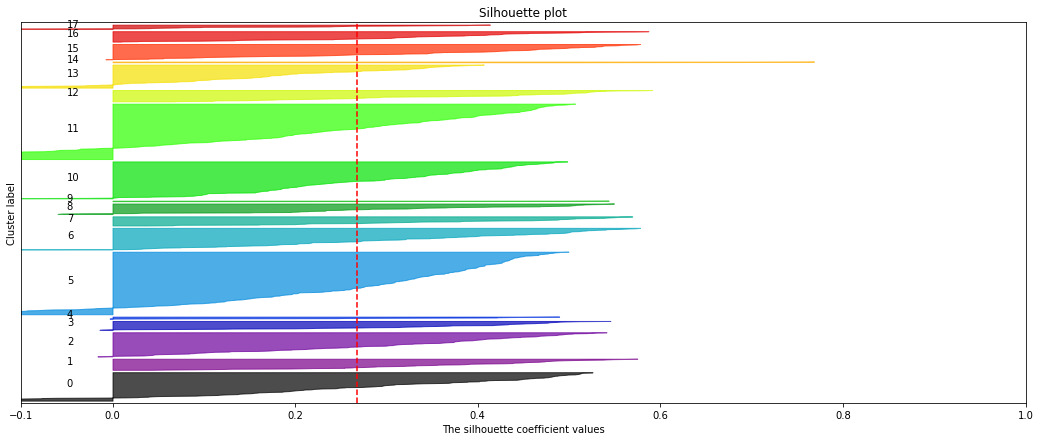

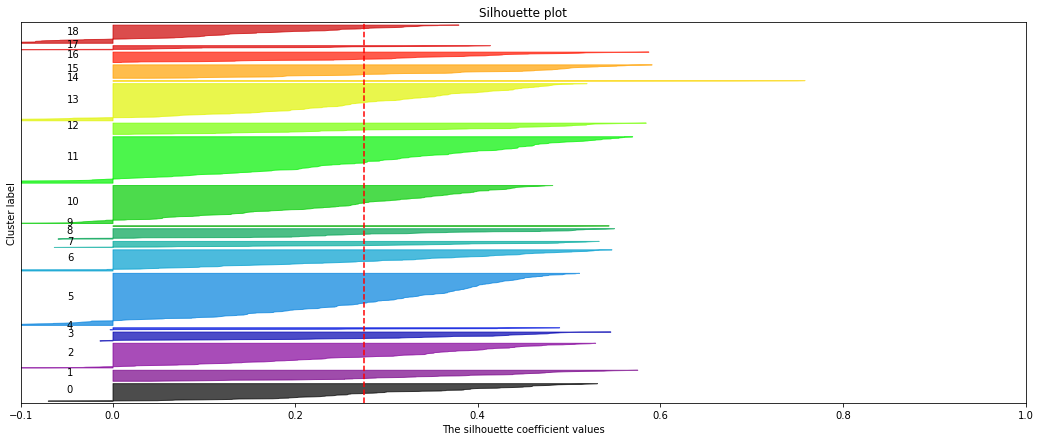

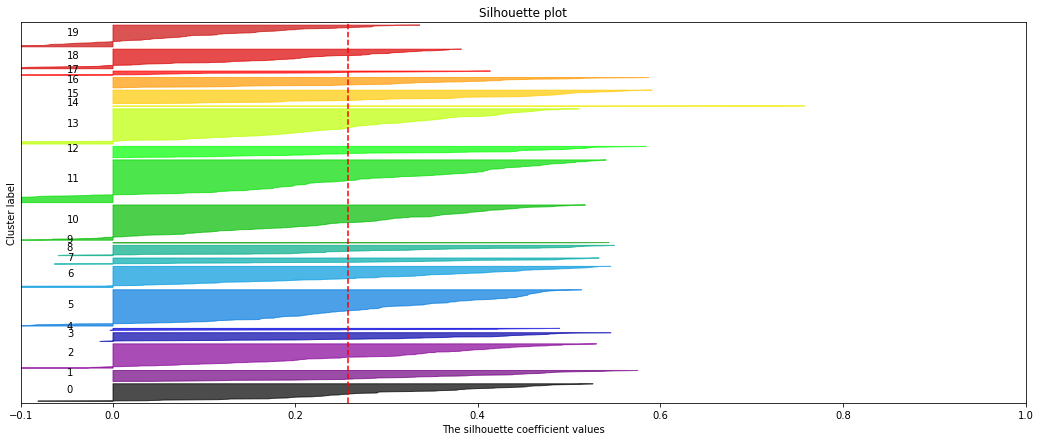

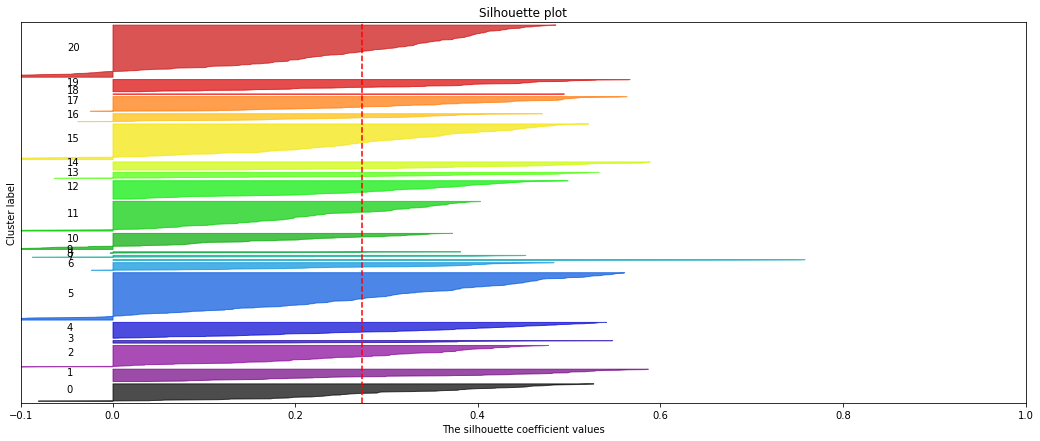

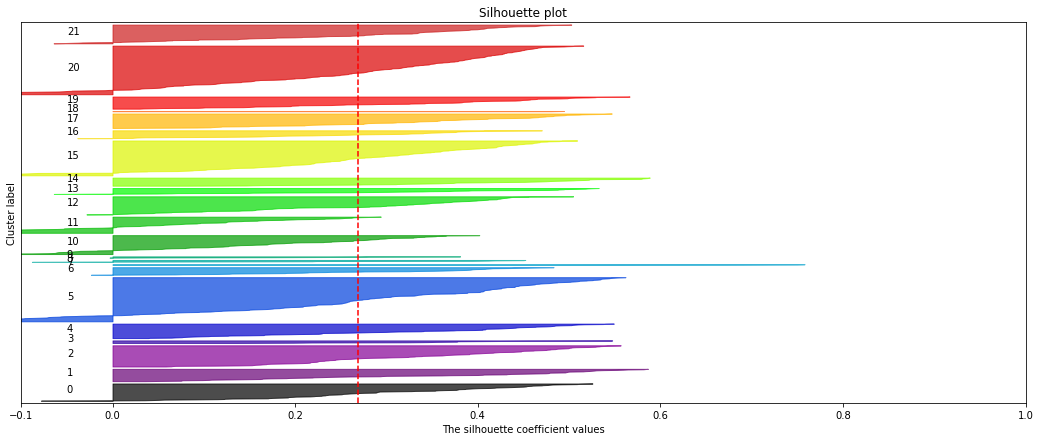

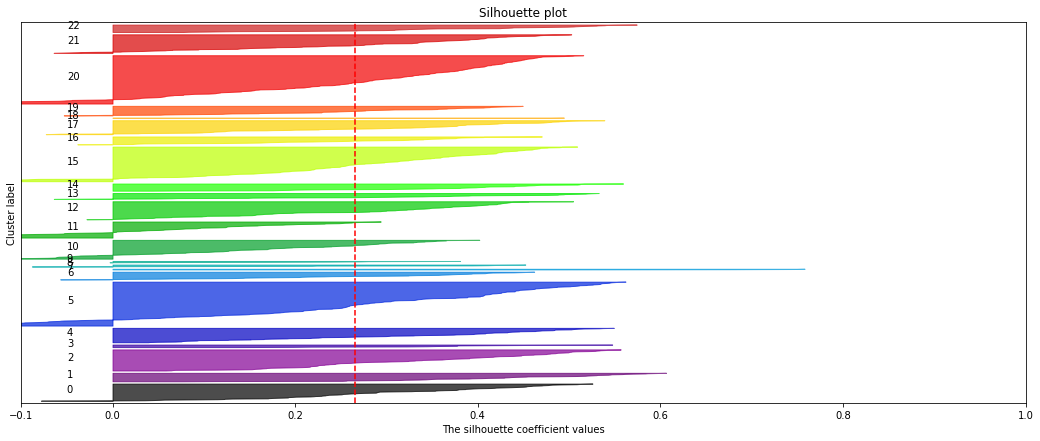

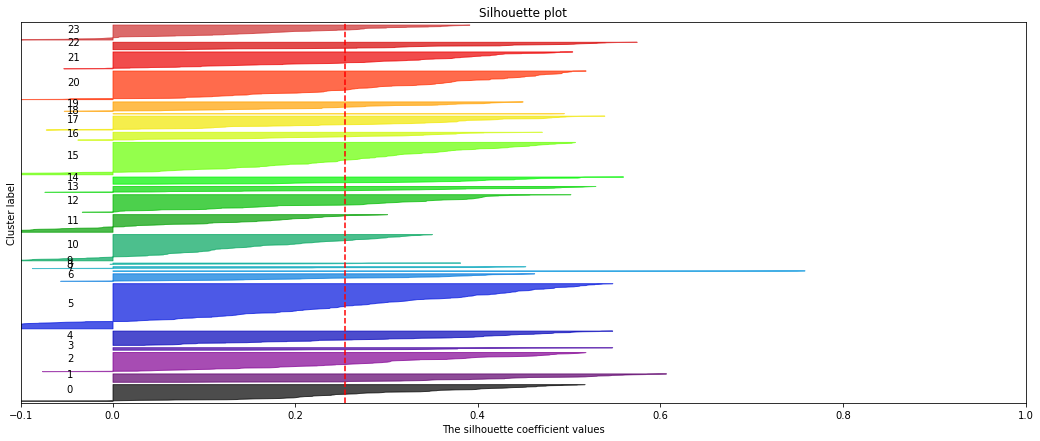

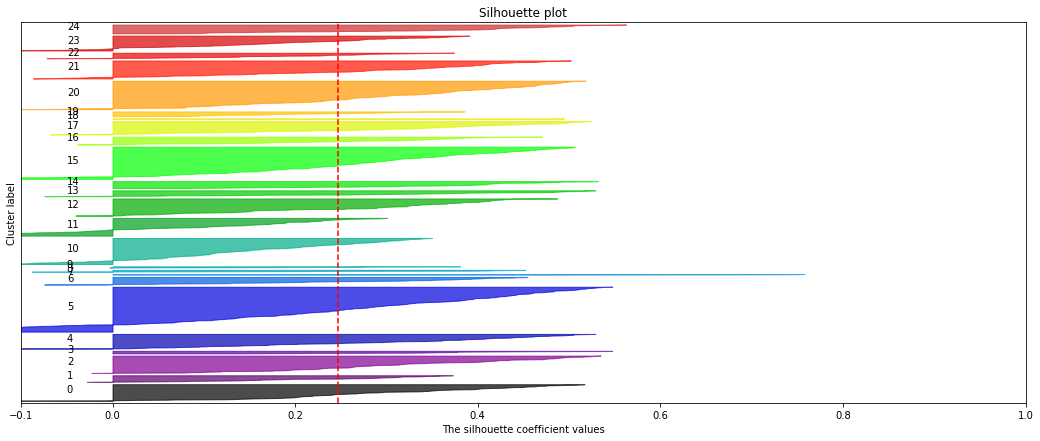

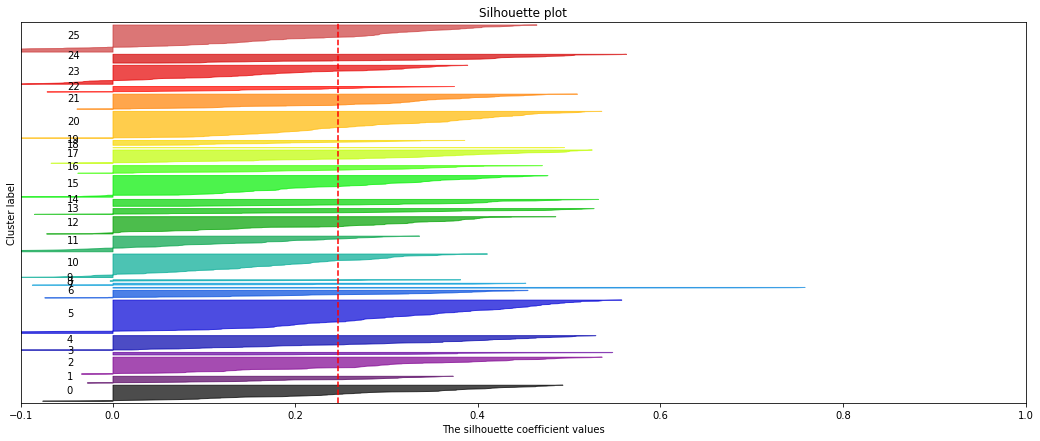

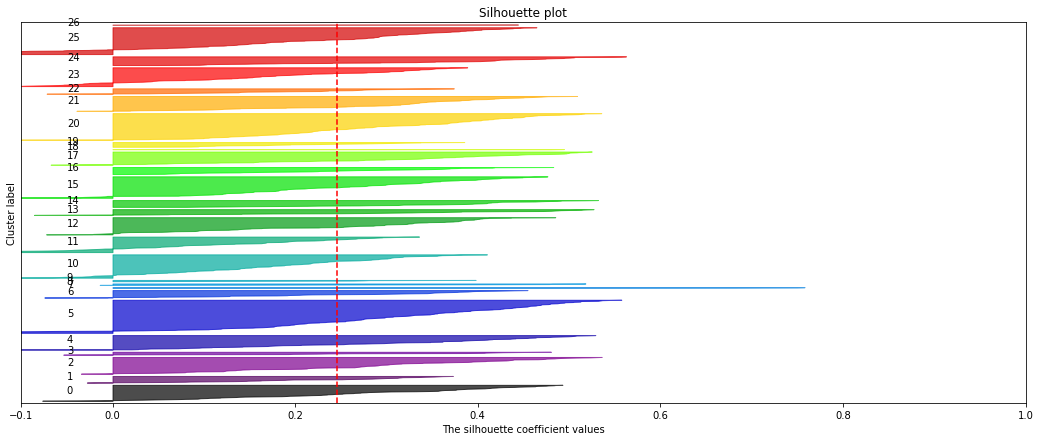

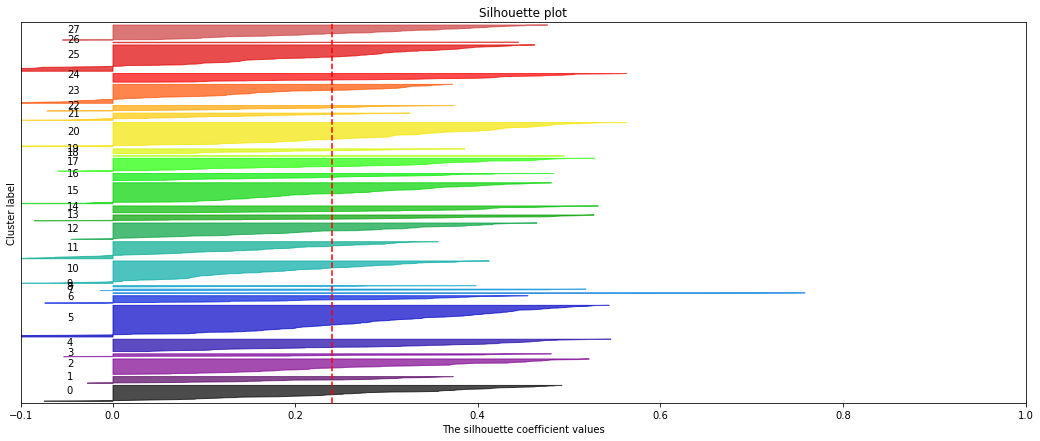

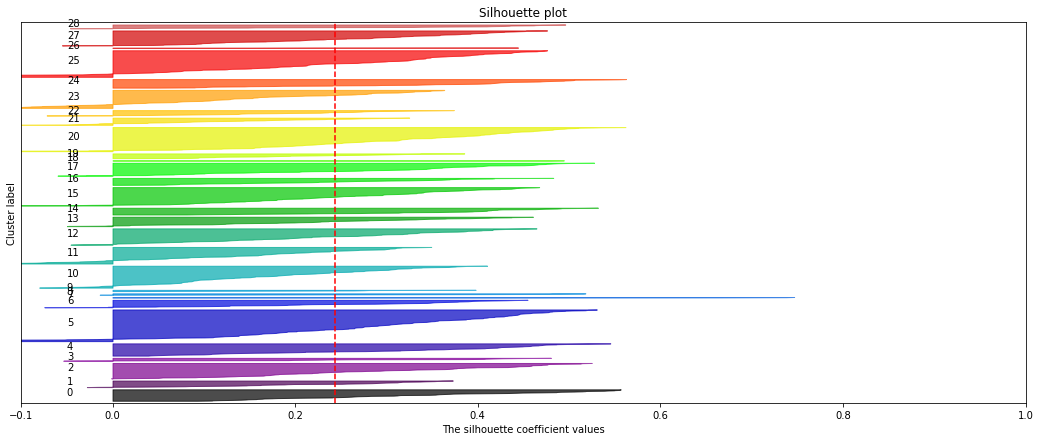

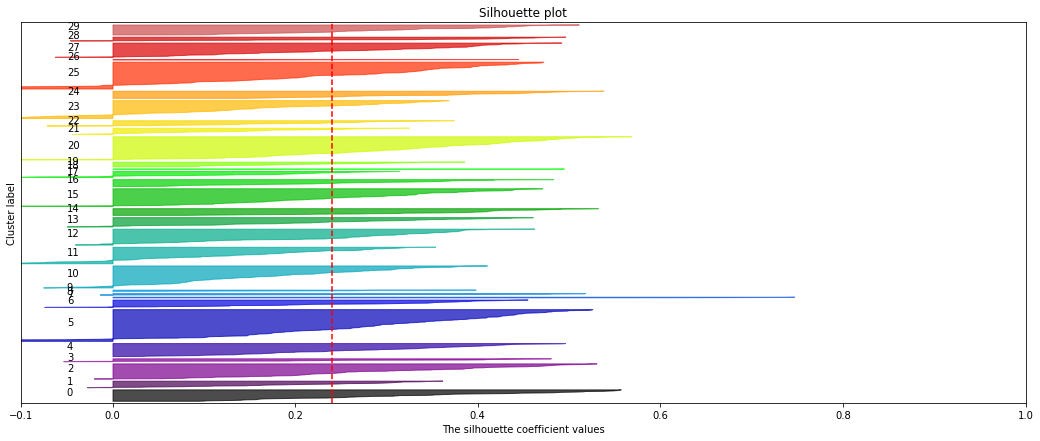

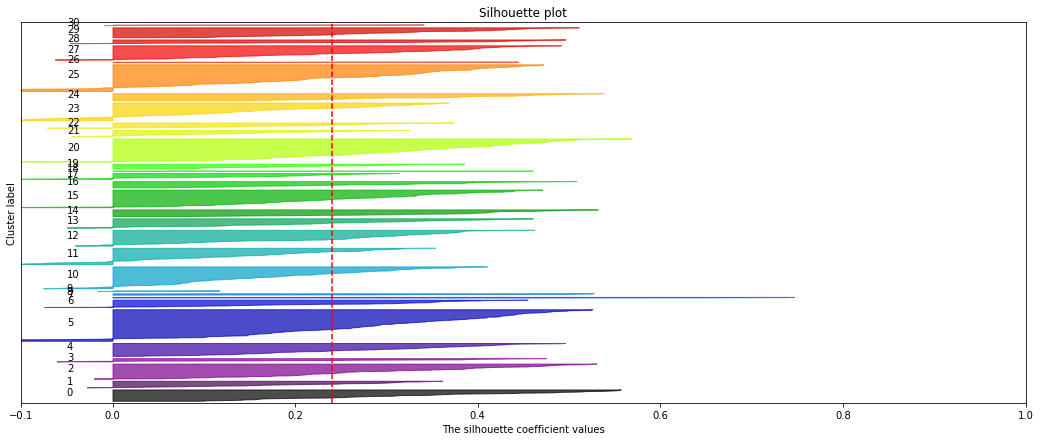

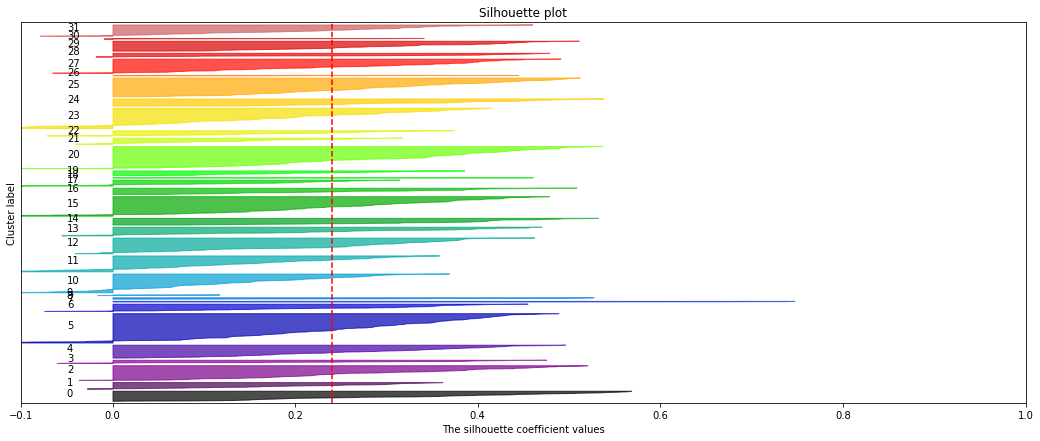

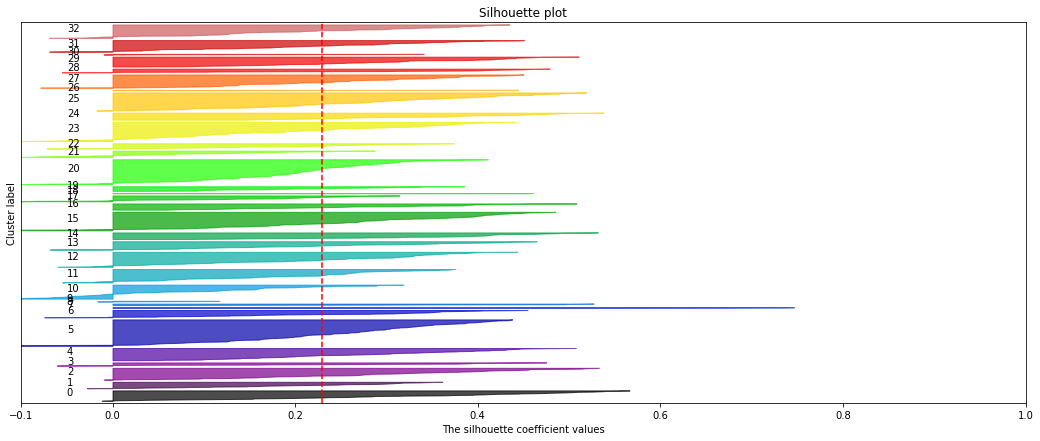

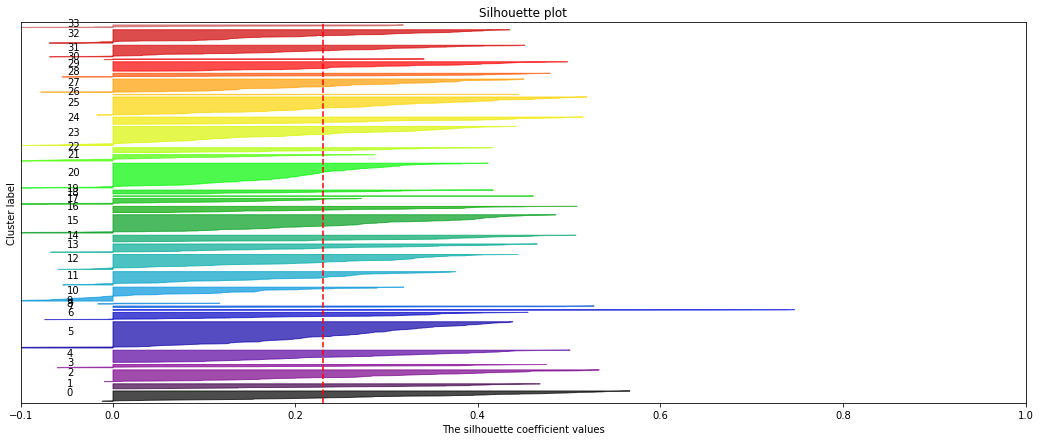

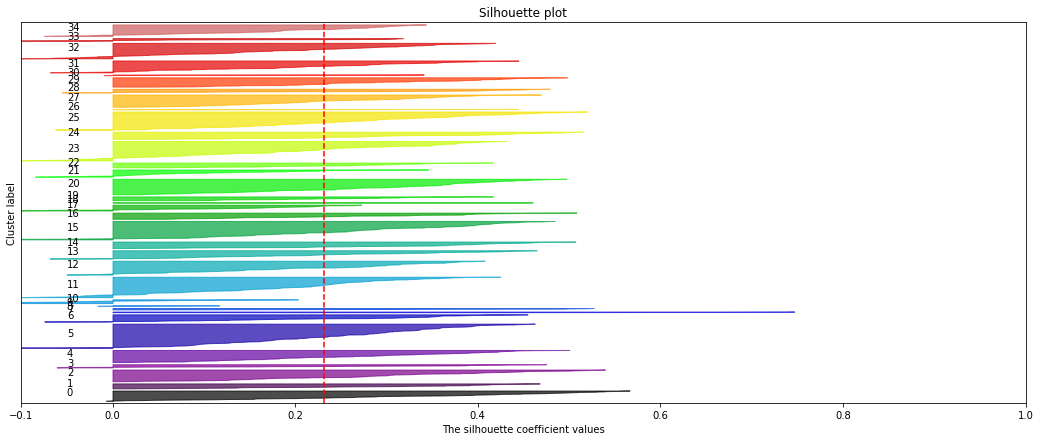

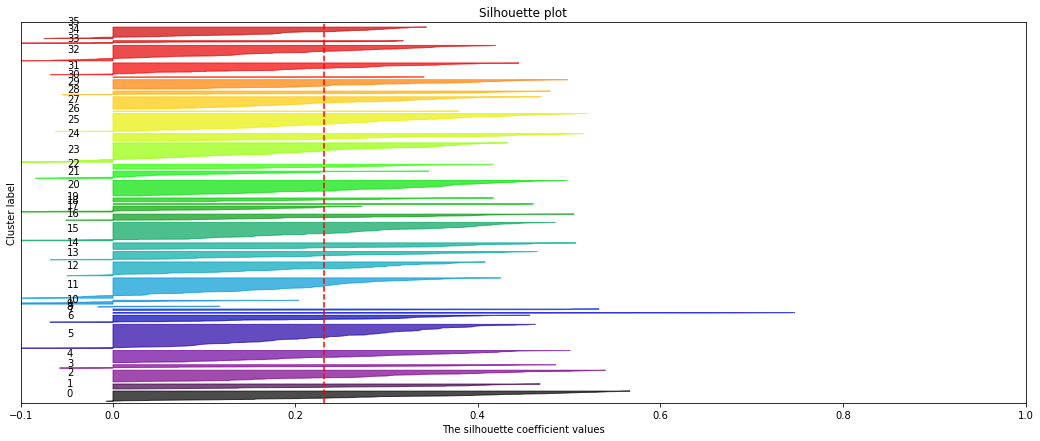

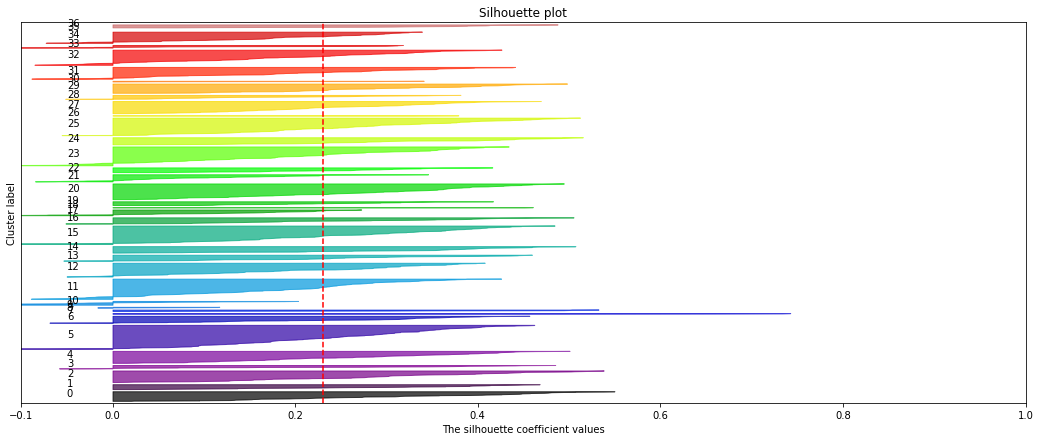

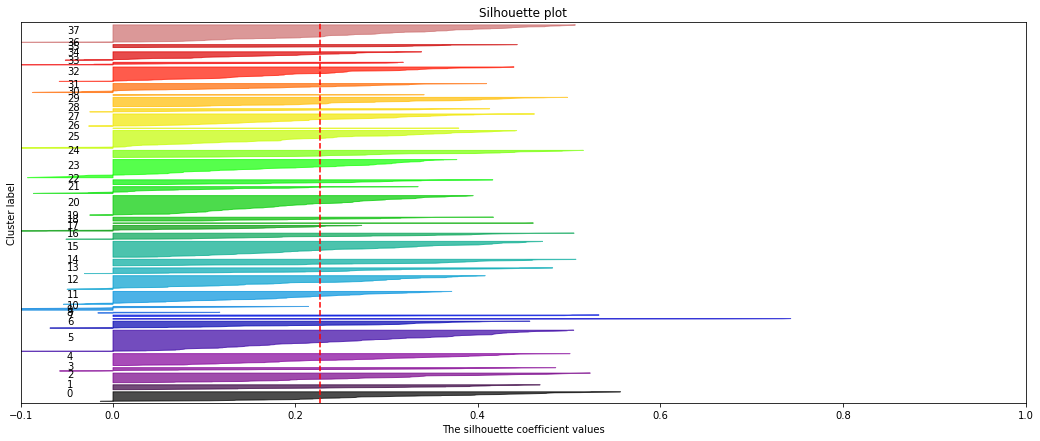

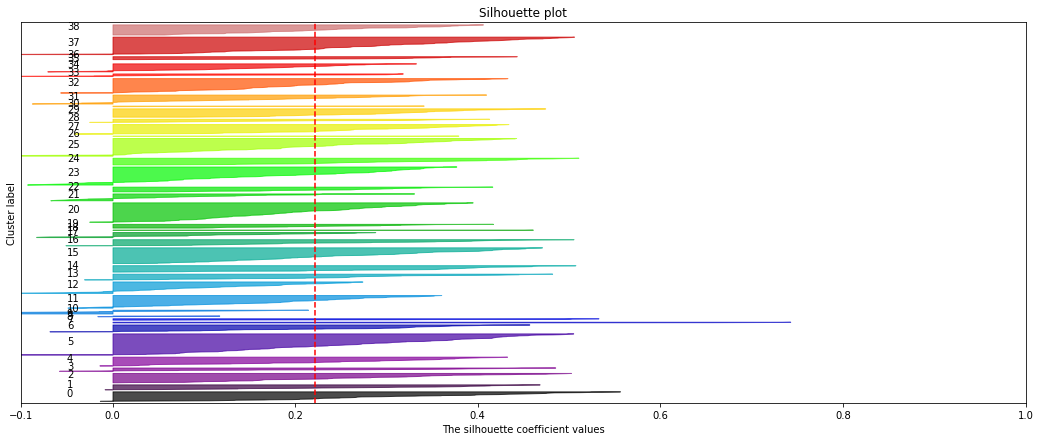

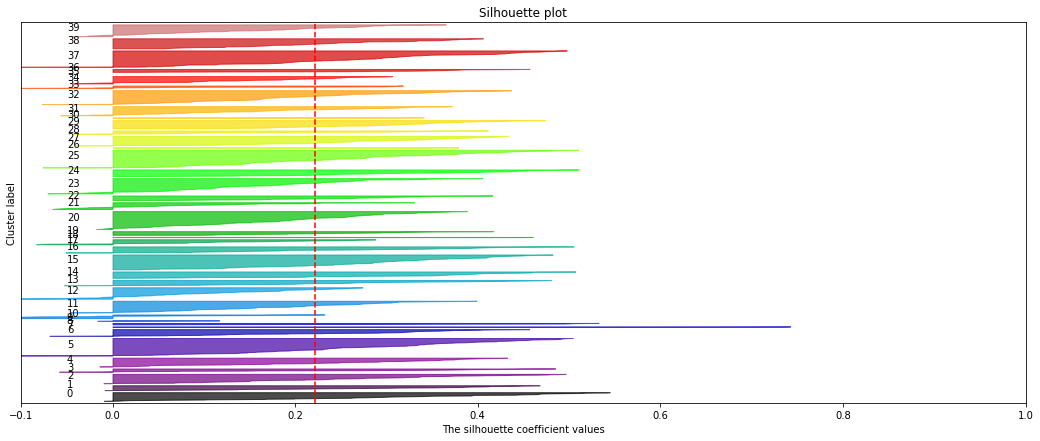

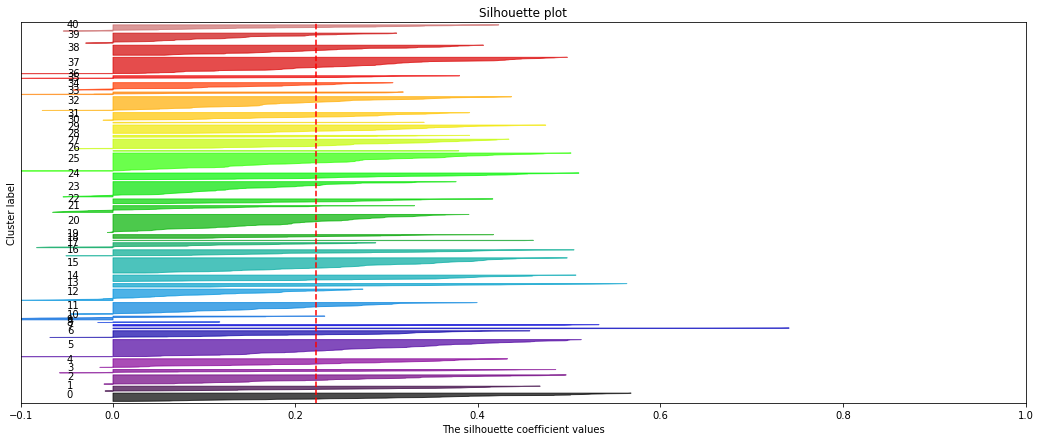

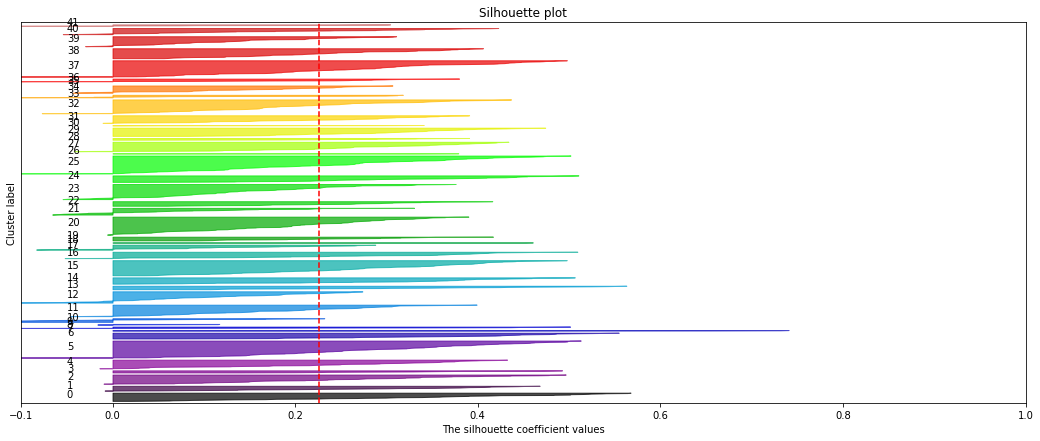

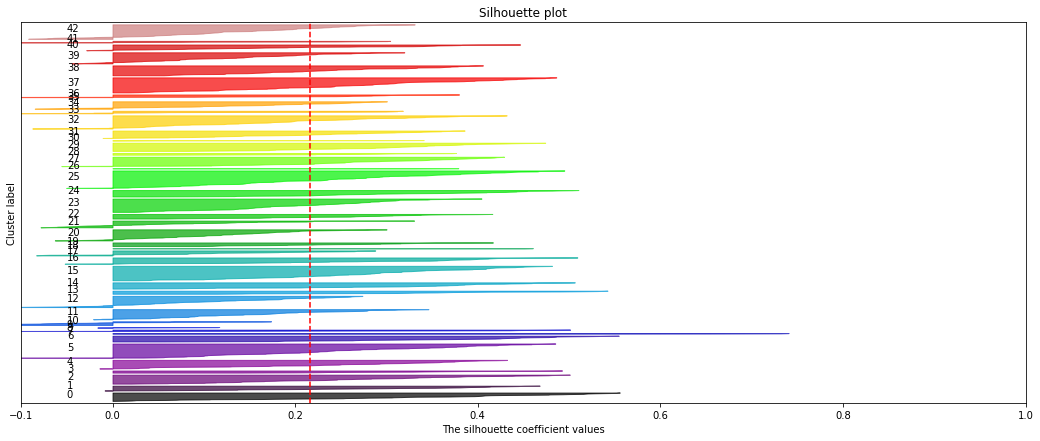

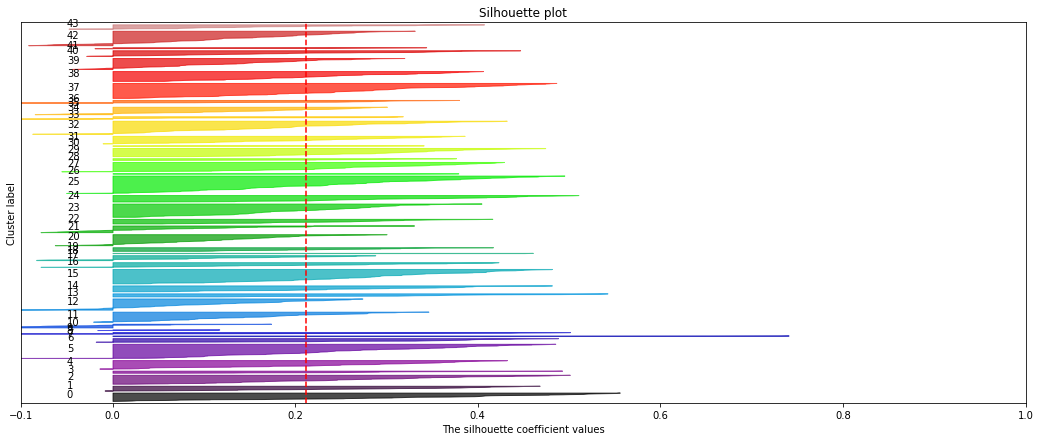

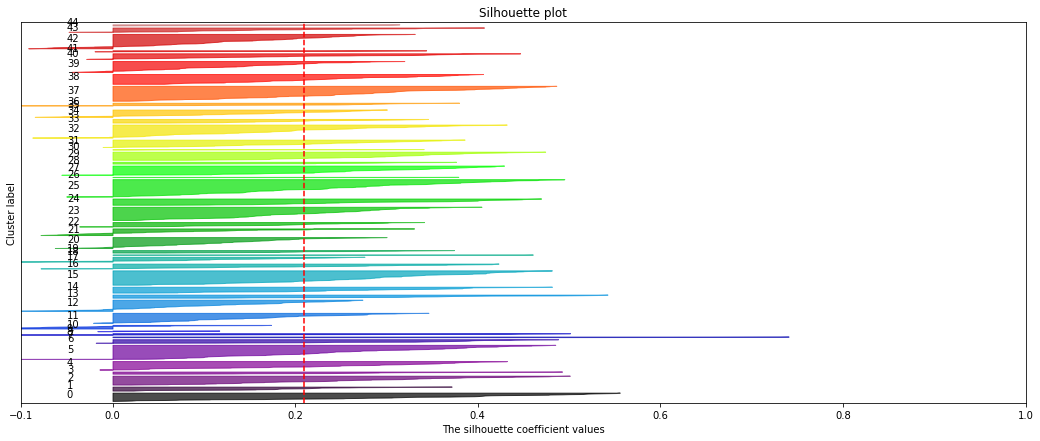

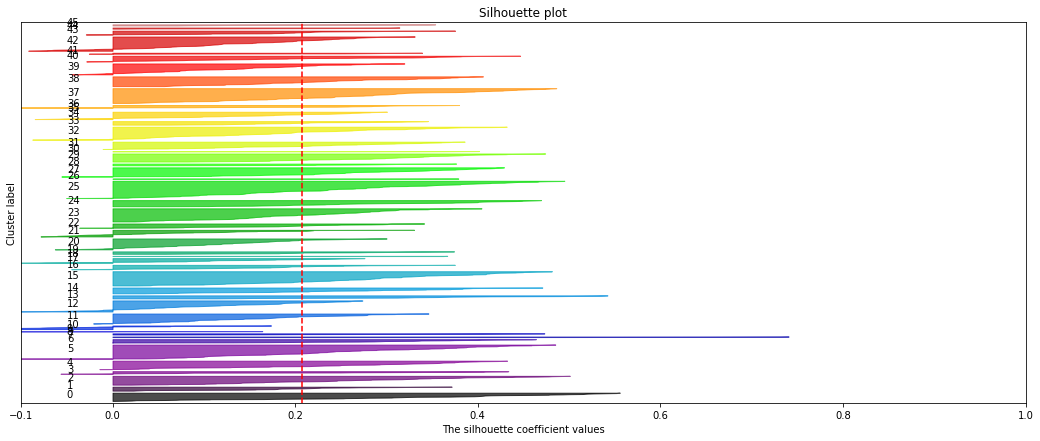

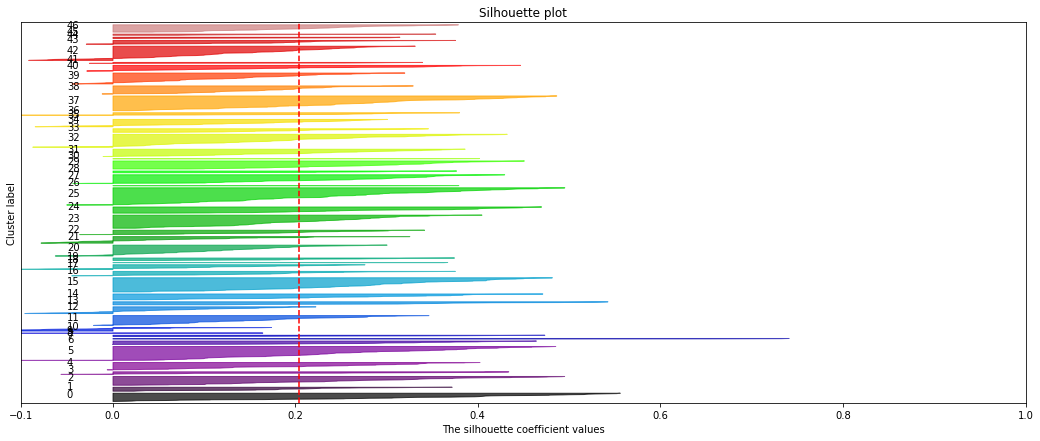

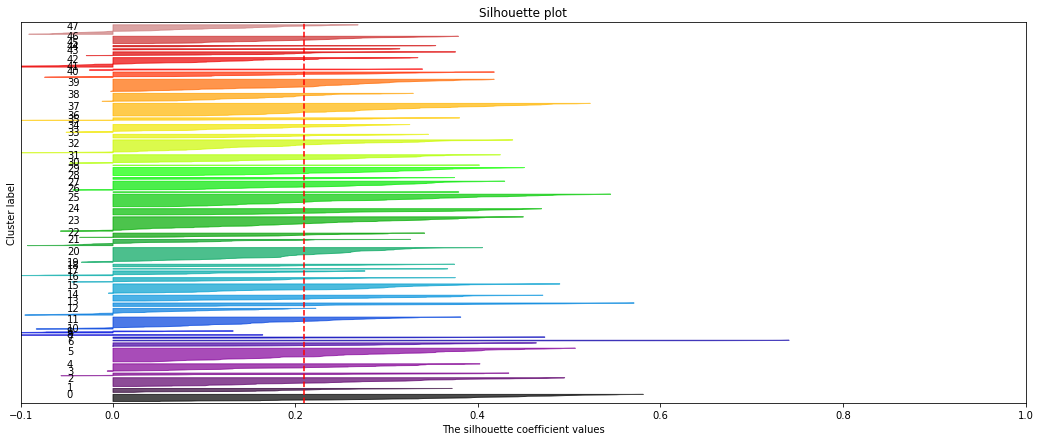

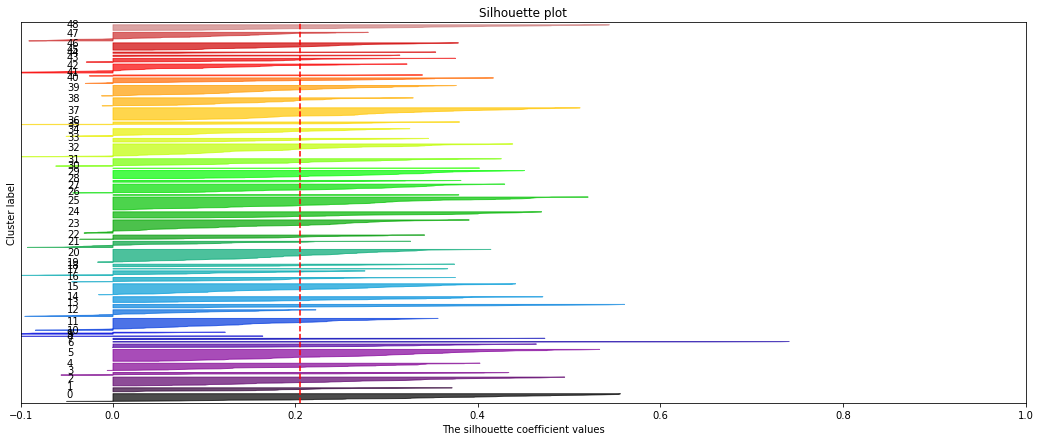

In [78]:
# Este código está adaptado desde el que está disponible la página de sklearn. 
# Se ha variado el algoritmo de clustering y la representación, donde solo nos interesa los clusters y no
# los centroides. ¡Ojo! Usamos el mismo random_state en todos los casos

sil_history = []
valores_k = range(2,50)
for k in valores_k:
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(espectros_latentes) + (k + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = GaussianMixture(n_components=k, random_state=21)
    cluster_labels = clusterer.fit_predict(espectros_latentes)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(espectros_latentes, cluster_labels)
    sil_history.append((silhouette_avg,k))
    print("For n_clusters =", k,
          "the average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(espectros_latentes, cluster_labels)

    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette plot")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

Vemos que los scores resultantes son bajos. En principio, tomaremos 11 (eliminamos la opción de dos y tres clusters), pero el score es de 0.34.

Listamos estos scores, ordenados de mayor a menor (aquí solo mostramos los 5 primeros).

In [79]:
sorted(sil_history, key=lambda x: x[0], reverse= True)[:5]

[(0.607328, 2),
 (0.40587613, 3),
 (0.3383935, 11),
 (0.33536717, 8),
 (0.32185197, 10)]

Por tanto, usamos GMM con 19 clusters. Hay que tener en cuenta que cada vez que ejecutemos el algoritmo, saldrán valores diferentes. De momento, fijamos una semilla de 21 para reproducibilidad, pero esto hay que tratarlo de otra forma. Podemos investigar el método utilizado por Jorge Sánchez con ASK.

In [80]:
num_clusters = 11

In [81]:
clustering = GaussianMixture(n_components=num_clusters, random_state=21).fit(espectros_latentes)
labels = clustering.predict(espectros_latentes)
labels_proba = clustering.predict_proba(espectros_latentes)

num_elems_clusters = np.unique(labels, return_counts=True)
num_elems_clusters[1]

array([341, 101, 166,  64,  16, 433, 122,  38,  77,   8, 197])

In [82]:
labels

array([0, 0, 1, ..., 5, 5, 5])

In [83]:
labels_proba.shape

(1563, 11)

In [84]:
probs = [labels_proba[i].max() for i in range(labels_proba.shape[0])]
np.sum(probs)

1561.4596309685219

In [85]:
outliers_gmm = [(probs[i], i) for i in range(len(probs)) if probs[i] < 0.99]
outliers_gmm

[(0.6323307633343584, 278),
 (0.6984757218903375, 607),
 (0.6102669459898862, 753),
 (0.8975347269543709, 1137),
 (0.9857777316389862, 1179),
 (0.7721944288433744, 1196),
 (0.9873444894151654, 1283),
 (0.9418683575659642, 1431)]

Es decir, casi todos los elementos tiene una probabilidad de pertenencia del 100% o de más de un 99%, por lo que, en teoría, la asignación es muy segura. Solo 8 tienen una probabilidad menor de 0.99

In [86]:
labels_proba[753]

array([0.00000000e+000, 1.30691288e-021, 3.89733054e-001, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 6.10266946e-001, 0.00000000e+000,
       3.16605686e-235, 0.00000000e+000, 0.00000000e+000])

Visualicemos algunos de los clusters. Modificamos la función de graficado para que se muestren los espectros latentes, estandarizados y originales en una sola fila.

In [87]:
clusters = []
for i in range(num_clusters):
    clusters.append(np.where(labels==i))

In [88]:
clusters[0][0]

array([   0,    1,    3,    5,    7,   11,   16,   18,   19,   25,   29,
         31,   35,   45,   49,   50,   51,   52,   55,   58,   60,   61,
         64,   66,   69,   75,   79,   82,   90,   95,  100,  101,  105,
        107,  111,  113,  120,  133,  138,  140,  141,  151,  155,  157,
        158,  164,  180,  187,  199,  200,  201,  208,  212,  222,  229,
        230,  231,  233,  240,  241,  242,  246,  248,  253,  257,  263,
        266,  267,  268,  271,  272,  274,  276,  285,  287,  289,  295,
        299,  309,  311,  316,  318,  321,  328,  329,  332,  343,  344,
        345,  347,  357,  361,  368,  383,  386,  388,  389,  399,  403,
        405,  407,  412,  416,  420,  423,  432,  433,  434,  435,  436,
        445,  447,  449,  457,  464,  467,  468,  475,  476,  478,  485,
        486,  492,  494,  495,  513,  515,  516,  517,  519,  521,  523,
        526,  527,  533,  541,  548,  553,  555,  557,  558,  560,  562,
        563,  564,  568,  572,  575,  576,  584,  5

In [89]:
def grafica_cluster(cluster, num_graf=10):
    print("Cluster: ", cluster)
    
    # Si el cluster tiene menos de 10 unidades, dará error al intentar representarlo. Corregimos esto.
    if len(clusters[cluster][0]) < num_graf:
        num_graf2 = len(clusters[cluster][0])
    else:
        num_graf2 = num_graf
    
    for n in range(1, num_graf2+1):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        fig.set_size_inches(17, 20)
        # Gráficas de los espectros latentes
        ax1 = plt.subplot(num_graf2, 3, (n*3)-2)
        ax1.plot(espectros_latentes[clusters[cluster][0][n]])
        plt.title("Latentes")
        # Gráficas de los espectros originales estandarizados
        ax2 = plt.subplot(num_graf2, 3, (n*3)-1)
        espectros_scaled.iloc[clusters[cluster][0][n]].plot()
        plt.title("Estandarizados")
        # Gráficas de los espectros originales sin estandarizar
        ax3 = plt.subplot(num_graf2, 3, (n*3))
        data.iloc[clusters[cluster][0][n]].plot()
        plt.title("Originales")
        #plt.savefig('espectros.png')

Cluster:  3


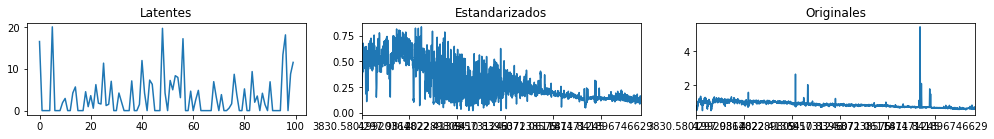

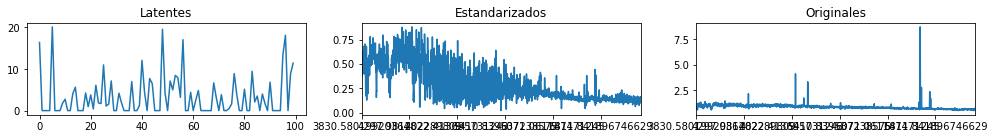

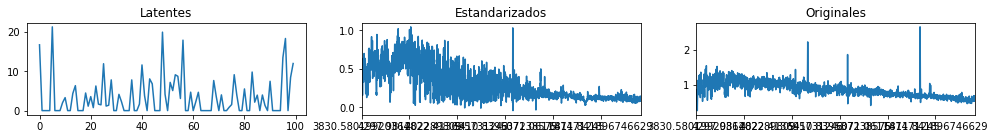

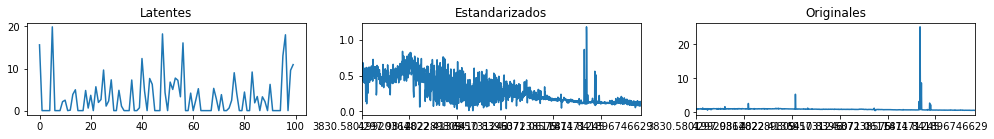

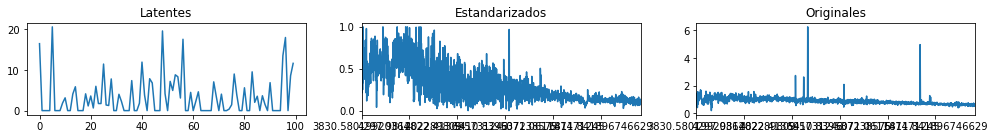

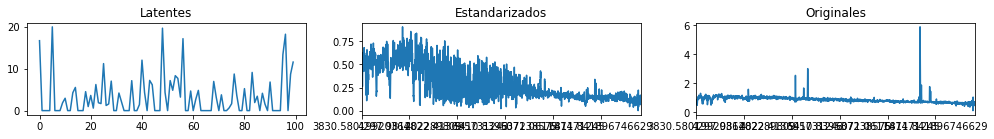

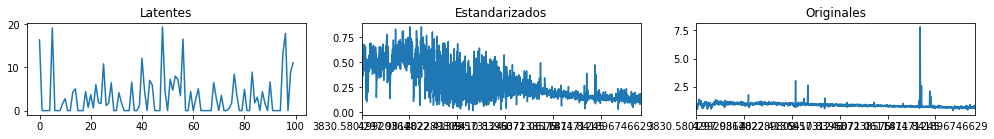

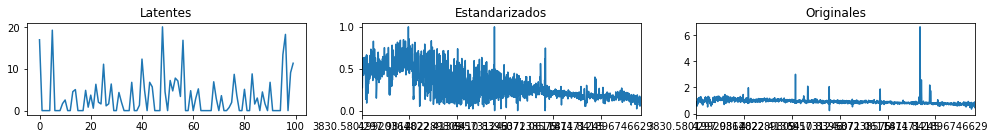

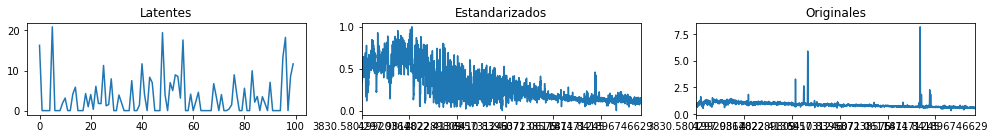

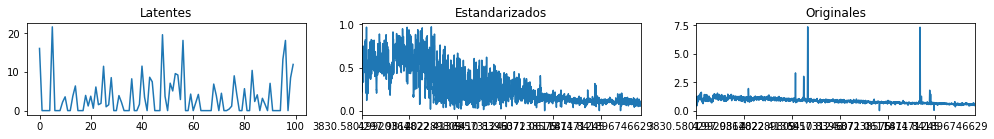

In [93]:
grafica_cluster(3)

La definición de estos clusters debe pasar por el estudiode Jorge y Ana, aunque en principio parece relativamente consistente. Sin embargo, el problema aquí es el contrario al que teníamos con DBSCAN: no parece fácil sacar outliers, dado que las probabilidades de pertenenecia son muy altas en la inmensa mayoría parte de las muestras (casi todas son 1 y el resto son 0.99).